In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate

import numpy as np
import pandas as pd
import tensorflow_probability as tfp
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from scipy.stats import linregress

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')

import functools
import warnings

from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import curve_fit


In [38]:
def flatten(func):
    ''' Decorator to flatten function parameters '''
    @functools.wraps(func)
    def helper(*args, **kwargs):
        flat_args = [a if a is None else a.flatten() for a in args]
        return func(*flat_args, **kwargs)
    return helper

def validate_shape(func):
	''' Decorator to flatten all function input arrays, and ensure shapes are the same '''
	@functools.wraps(func)
	def helper(*args, **kwargs):
		flat     = [a.flatten() if hasattr(a, 'flatten') else a for a in args]
		flat_shp = [a.shape for a in flat if hasattr(a, 'shape')]
		orig_shp = [a.shape for a in args if hasattr(a, 'shape')]
		assert(all(flat_shp[0] == s for s in flat_shp)), f'Shapes mismatch in {func.__name__}: {orig_shp}'
		return func(*flat, **kwargs)
	return helper

def only_finite(func):
	''' Decorator to remove samples which are nan in any input array '''
	@validate_shape
	@functools.wraps(func)
	def helper(*args, **kwargs):
		stacked = np.vstack(args)
		valid   = np.all(np.isfinite(stacked), 0)
		assert(valid.sum()), f'No valid samples exist for {func.__name__} metric'
		return func(*stacked[:, valid], **kwargs)
	return helper

def only_valid(func):
    ''' Decorator to remove all elements having a nan in any array '''
    @functools.wraps(func)
    def helper(*args, **kwargs):
        assert(all([len(a.shape) == 1 for a in args]))
        stacked = np.vstack(args)
        valid = np.all(np.isfinite(stacked), 0)
        return func(*stacked[:, valid], **kwargs)
    return helper

def only_positive(func):
	''' Decorator to remove samples which are zero/negative in any input array '''
	@validate_shape
	@functools.wraps(func)
	def helper(*args, **kwargs):
		stacked = np.vstack(args)
		valid   = np.all(stacked > 0, 0)
		assert(valid.sum()), f'No valid samples exist for {func.__name__} metric'
		return func(*stacked[:, valid], **kwargs)
	return helper


def label(name):
    ''' Label a function for when it's printed '''
    def helper(f):
        f.__name__ = name
        return f
    return helper

@only_finite
@label('RMSE')
def rmse(y, y_hat):
	''' Root Mean Squared Error '''
	return np.mean((y - y_hat) ** 2) ** .5


@only_finite
@only_positive
@label('RMSLE')
def rmsle(y, y_hat):
	''' Root Mean Squared Logarithmic Error '''
	return np.mean(np.abs(np.log(y) - np.log(y_hat)) ** 2) ** 0.5


@only_finite
@label('NRMSE')
def nrmse(y, y_hat):
	''' Normalized Root Mean Squared Error '''
	return ((y - y_hat) ** 2).mean() ** .5 / y.mean()

@only_finite
@only_positive
@label('R^2')
def r_squared(y, y_hat):
	''' Logarithmic R^2 '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return r_value**2

@label('<=0')
@flatten
@only_valid
def leqz(y1, y2=None):
    ''' Less than or equal to zero (y2) '''
    if y2 is None: y2 = y1
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return (y2 <= 0).sum()


@label('<=0|NaN')
@flatten
def leqznan(y1, y2=None):
    ''' Less than or equal to zero (y2) '''
    if y2 is None: y2 = y1
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return np.logical_or(np.isnan(y2), y2 <= 0).sum()

@label('MAD')
@flatten
@only_valid
def MAD(y1, y2):
    ''' Mean Absolute Error '''
    i  = np.logical_and(y1 > 0, y2 > 0)
    y1 = np.log10(y1[i])
    y2 = np.log10(y2[i])
    i  = np.logical_and(np.isfinite(y1), np.isfinite(y2))
    y1 = y1[i]
    y2 = y2[i]
    return 10**np.mean(np.abs(y1 - y2))-1

@only_finite
@label('MdAPE')
def mape(y, y_hat):
	''' Mean Absolute Percentage Error '''
	return 100 * np.mean(np.abs((y - y_hat) / y))

@only_finite
@only_positive
@label('MSA')
def msa(y, y_hat):
	''' Mean Symmetric Accuracy '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	return 100 * (np.exp(np.mean(np.abs(np.log(y_hat / y)))) - 1)


@only_finite
@only_positive
@label('MdSA')
def mdsa(y, y_hat):
	''' Median Symmetric Accuracy '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	return 100 * (np.exp(np.median(np.abs(np.log(y_hat / y)))) - 1)

@only_finite
@only_positive
@label('SSPB')
def sspb(y, y_hat):
	''' Symmetric Signed Percentage Bias '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	M = np.median( np.log(y_hat / y) )
	return 100 * np.sign(M) * (np.exp(np.abs(M)) - 1)


@only_finite
@label('Bias')
def bias(y, y_hat):
	''' Mean Bias '''
	return np.mean(y_hat - y)

@only_finite
@only_positive
@label('Slope')
def slope(y, y_hat):
	''' Logarithmic slope '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return slope_


@only_finite
@only_positive
@label('Intercept')
def intercept(y, y_hat):
	''' Locarithmic intercept '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return intercept_

@validate_shape
@label('MWR')
def mwr(y, y_hat, y_bench):
	'''
	Model Win Rate - Percent of samples in which model has a closer
	estimate than the benchmark.
		y: true, y_hat: model, y_bench: benchmark
	'''
	y_bench[y_bench < 0] = np.nan
	y_hat[y_hat < 0] = np.nan
	y[y < 0] = np.nan
	valid = np.logical_and(np.isfinite(y_hat), np.isfinite(y_bench))
	diff1 = np.abs(y[valid] - y_hat[valid])
	diff2 = np.abs(y[valid] - y_bench[valid])
	stats = np.zeros(len(y))
	stats[valid]  = diff1 < diff2
	stats[~np.isfinite(y_bench)] = 1
	stats[~np.isfinite(y_hat)] = 0
	return stats.sum() / np.isfinite(y).sum()

def performance(key, y1, y2, metrics=[rmse, slope, msa, rmsle, sspb, MAD, leqznan]):#[rmse, rmsle, mape, r_squared, bias, mae, leqznan, slope]):
    ''' Return a string containing performance using various metrics.
        y1 should be the true value, y2 the estimated value. '''
    return '%8s | %s' % (key, '   '.join([
            '%s: %6.3f' % (f.__name__, f(y1,y2)) for f in metrics]))

In [39]:
base_path = 'C:/SwitchDrive/Data/datasets_train_test/'

# Load the three in situ scenarios
random_train_df = pd.read_csv(f'{base_path}/random_df_train_org.csv')
random_test_df = pd.read_csv(f'{base_path}/random_df_test_org.csv')

wd_train_df = pd.read_csv(f'{base_path}/wd_train_set_org.csv')
wd_test_df = pd.read_csv(f'{base_path}/wd_test_set_org.csv')

ood_train_df = pd.read_csv(f'{base_path}/ood_train_set_2.csv')
ood_test_df = pd.read_csv(f'{base_path}/ood_test_set_2.csv')

filtered_df = pd.read_csv(f'{base_path}/filtered_df_2319.csv')

C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\601386887.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  random_test_df = pd.read_csv(f'{base_path}/random_df_test_org.csv')
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\601386887.py:7: DtypeWarning: Columns (3,4,5,6,8,11,27,33,34,37,39,48,50,51,52,54,55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_train_df = pd.read_csv(f'{base_path}/wd_train_set_org.csv')
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\601386887.py:8: DtypeWarning: Columns (4,5,34,37,39,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_test_df = pd.read_csv(f'{base_path}/wd_test_set_org.csv')
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\601386887.py:13: DtypeWarning: Columns (3,4,5,6,8,27,33,34,37,39,48,50,51,52,54,55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_df = p

In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# Select Rrs values in 5 nm steps
rrs_columns = [f'Rrs_{nm}' for nm in range(400, 701, 5)]
X_train = random_train_df[rrs_columns].values
X_test = random_test_df[rrs_columns].values

# Extracting target variables
y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
y_train = random_train_df[y_columns].values
y_test = random_test_df[y_columns].values

#Apply log transformation to the target variables
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

#Apply Min-Max scaling to log-transformed target variables
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_test_scaled = scaler_y.transform(y_test_log)


In [18]:
def custom_mdn_loss(num_components, num_targets, epsilon=1e-6):
    """

    The loss function computes the negative log likelihood of the true data given the predicted mixture distribution,
    which consists of a specified number of multivariate normal components. The NN outputs are split into
    mixing coefficients, means, and Cholesky decomposition parameters for the covariance matrices.

    Args:
        num_components (int): The number of mixture components (e.g., the number of Gaussian distributions in the mixture).
        num_targets (int): The dimensionality of the target space (e.g., the number of variables being predicted).
        epsilon (float, optional): Small value to ensure stability when constructing covariance matrices.
                                   Default is 1e-6.

    Returns:
        function: A loss function that can be used in model compilation.

    The returned loss function operates as follows:

    1. Splits the predicted values (`y_pred`) into mixing coefficients (`pi`), means (`mu`), and Cholesky decomposition
       parameters (`chol_params`).
    2. Applies a softmax function to the mixing coefficients to ensure they sum to 1.
    3. Reshapes the means and Cholesky decomposition parameters to the appropriate dimensions.
    4. Constructs the Cholesky lower triangular matrices from the Cholesky parameters.
    5. Adds `epsilon` to the diagonal elements of the Cholesky matrices to ensure positive definiteness.
    6. Defines a mixture of multivariate normal distributions using the reshaped parameters.
    7. Computes and returns the negative log likelihood of the true y given the mixture distribution (mix).

    Note:
          `num_components * (1 + num_targets + num_targets * (num_targets + 1) // 2)`.
    """
    def loss(y_true, y_pred):
        # Split y_pred into its components: mixing coefficients (pi), means (mu), and Cholesky decomposition parameters (chol_params)
        split_sizes = [num_components, num_components * num_targets, num_components * num_targets * (num_targets + 1) // 2]
        pi, mu, chol_params = tf.split(y_pred, num_or_size_splits=split_sizes, axis=-1)
        pi = tf.nn.softmax(pi, axis=-1)  # Softmax to get mixing coefficients

        # Reshape mu and chol_params to match the desired dimensions
        mu = tf.reshape(mu, [-1, num_components, num_targets])
        chol_params = tf.reshape(chol_params, [-1, num_components, num_targets * (num_targets + 1) // 2])

        # Create covariance matrices from the Cholesky parameters
        chol_matrices = tfp.math.fill_triangular(chol_params)
        # Ensure positive definiteness of covariance matrices
        chol_matrices += epsilon * tf.linalg.eye(num_targets, batch_shape=[tf.shape(y_pred)[0], num_components])

        # Define the mixture of Multivariate Normal distributions
        components = tfp.distributions.MultivariateNormalTriL(loc=mu, scale_tril=chol_matrices)
        mixture = tfp.distributions.Categorical(probs=pi)
        mix = tfp.distributions.MixtureSameFamily(mixture_distribution=mixture, components_distribution=components)

        # Use mix: compute the log likelihood of the data given the model
        likelihood = mix.log_prob(y_true)

        # Return the negative log likelihood as the loss
        return -tf.reduce_mean(likelihood)

    return loss

def build_mdn_wavelength_specific(input_shape, n_mix=5, hidden=[100, 100, 100, 100, 100], lr=1e-3, l2_reg=1e-3, activation='relu', num_targets=6):
    """
    Build the MDN.

    Args:
        input_shape (int): The shape of the input data.
        n_mix (int): The number of mixture components (default is 5).
        hidden (list): A list of integers specifying the number of units in each hidden layer (default is [100, 100, 100, 100, 100]).
        lr (float): The learning rate for the optimizer (default is 1e-3).
        l2_reg (float): The L2 regularization factor (default is 1e-3).
        activation (str): The activation function to use in the hidden layers (default is 'relu').
        num_targets (int): The dimensionality of the target space (default is 6).

    Returns:
        Model: ready for training.
    """
    inputs = Input(shape=(input_shape,))
    x = inputs
    for units in hidden:
        x = Dense(units, activation=activation, kernel_regularizer=l2(l2_reg))(x)
    pi = Dense(n_mix, activation='softmax', name='pi')(x)
    mu = Dense(n_mix * num_targets, activation=None, name='mu')(x)

    # Calculate the size for Cholesky decomposition parameters
    chol_size = n_mix * num_targets * (num_targets + 1) // 2
    chol_params = Dense(chol_size, activation=None, name='chol')(x)

    outputs = Concatenate(axis=-1)([pi, mu, chol_params])

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Pass the correct parameters to the custom MDN loss function
    mdn_loss = custom_mdn_loss(n_mix, num_targets)
    model.compile(optimizer=optimizer, loss=mdn_loss)
    return model

def train_mdn(model, X_train, y_train, epochs=100, batch_size=32):
    """
    Train the MDN.

    Args:
        model (Model): The MDN model to be trained.
        X_train (np.ndarray): The training input data.
        y_train (np.ndarray): The training target data.
        epochs (int): The number of epochs to train the model (default is 100).
        batch_size (int): The size of the training batches (default is 32).

    Returns:
        Model, training history.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    # Fit the model with a validation split of 10%
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])

    return model, history

# Define the number of mixture components and target variables
n_mix = 5
num_targets = 6

# Build the MDN
model = build_mdn_wavelength_specific(input_shape=X_train.shape[1], n_mix=n_mix, hidden=[100, 100, 100, 100, 100], lr=1e-3, l2_reg=1e-3, activation='relu', num_targets=num_targets)

# Train the MDN
mdn_model, mdn_hist = train_mdn(model, X_train, y_train_scaled, epochs=500, batch_size=32)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 494.2045 - val_loss: 4.5625
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7176 - val_loss: 2.8057
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4311 - val_loss: 1.6703
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1963 - val_loss: 0.7855
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3665 - val_loss: 0.0708
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.1697 - val_loss: -0.4711
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.5452 - val_loss: -0.4145
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.7248 - val_loss: -0.9540
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.2248 - val_loss: -1.0487
Epoch 10/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.4102 - val_loss: -1.1922
Epoch 11/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.4344 - val_loss: -1.4932
Epoch 12/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

In [19]:
# Generate preds
raw_predictions = mdn_model.predict(X_test)

n_mix = 5  # Number of mixture components
num_targets = 6  # Number of target variables

def split_mdn_outputs(raw_predictions, num_components, num_targets):
    """
    Split the raw prdictions into pi, mu and chol parameters.

    Args:
        raw_predictions (tf.Tensor): The raw output from the MDN model, with shape [batch_size, num_components * (1 + num_targets + num_targets * (num_targets + 1) // 2)].
        num_components (int): The number of mixture components (i.e., the number of Gaussian distributions in the mixture).
        num_targets (int): The dimensionality of the target space.

    Returns:
        pi (tf.Tensor): The mixing coefficients for each component, with shape [batch_size, num_components].
        mu (tf.Tensor): The means of the Gaussian components, with shape [batch_size, num_components, num_targets].
        chol_params (tf.Tensor): The Cholesky decomposition parameters for the covariance matrices of the Gaussian components, with shape [batch_size, num_components, num_targets * (num_targets + 1) // 2].

    The function operates as follows:

    1. Splits the `raw_predictions` tensor into three parts:
       - `pi`: Mixing coefficients of shape [batch_size, num_components].
       - `mu`: Means of shape [batch_size, num_components * num_targets].
       - `chol_params`: Cholesky decomposition parameters of shape [batch_size, num_components * num_targets * (num_targets + 1) // 2].
    2. Applies a softmax function to `pi` to ensure the mixing coefficients sum to 1.
    3. Reshapes `mu` to [batch_size, num_components, num_targets].
    4. Reshapes `chol_params` to [batch_size, num_components, num_targets * (num_targets + 1) // 2].
    """
    split_sizes = [num_components, num_components * num_targets, num_components * num_targets * (num_targets + 1) // 2]
    pi, mu, chol_params = tf.split(raw_predictions, num_or_size_splits=split_sizes, axis=-1)
    pi = tf.nn.softmax(pi, axis=-1)  # Ensure mixing coefficients sum to 1
    return pi, mu, chol_params

# Apply
pi, mu, chol_params = split_mdn_outputs(raw_predictions, n_mix, num_targets)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [20]:
def mdn_total_uncertainty(pi, mu, chol_params, num_components, num_targets, scaler_y):
    """
    Calculate the mean predictions, aleatoric variance, epistemic variance, and total variance for the MDN.

    Args:
        pi (tf.Tensor): Mixing coefficients of shape [batch_size, num_components].
        mu (tf.Tensor): Means of the mixture components of shape [batch_size, num_components * num_targets].
        chol_params (tf.Tensor): Cholesky decomposition parameters of shape [batch_size, num_components * num_targets * (num_targets + 1) // 2].
        num_components (int): The number of mixture components.
        num_targets (int): The dimensionality of the target space.
        scaler_y (sklearn.preprocessing.MinMaxScaler): Scaler used to transform the target variables.

    Returns:
        mean_predictions (np.ndarray): Mean predictions in the original space of shape [batch_size, num_targets].
        total_variance (np.ndarray): Total variance in the original space of shape.
        aleatoric_variance (np.ndarray): Aleatoric variance in the original space.
        epistemic_variance (np.ndarray): Epistemic variance in the original space.
        std_devs (np.ndarray): Standard deviations in the original space.
    """
    # Reshape pi and mu
    pi = tf.reshape(pi, [-1, num_components, 1])
    mu = tf.reshape(mu, [-1, num_components, num_targets])

    # Calculate the mean predictions (expected means)
    mean_predictions = tf.reduce_sum(pi * mu, axis=1)  # mean_predictions shape: [batch_size, num_targets]

    # Reshape chol_params and calculate Sigma
    chol_elements = num_targets * (num_targets + 1) // 2
    chol_matrices = tf.reshape(chol_params, [-1, num_components, chol_elements])
    L = tfp.math.fill_triangular(chol_matrices)
    Sigma = tf.matmul(L, L, transpose_b=True)  # [batch_size, num_components, num_targets, num_targets]

    # Aleatoric var
    variances = tf.linalg.diag_part(Sigma)  # [batch_size, num_components, num_targets]
    aleatoric_variance = tf.reduce_sum(pi * variances, axis=1)  # [batch_size, num_targets]

    # Epistemic var
    mu_weighted = pi * mu  # Weight means by their mixture probabilities
    mu_squared_weighted = pi * tf.square(mu)  # Weight squared means by their mixture probabilities
    expected_mu_squared = tf.reduce_sum(mu_squared_weighted, axis=1)  # [batch_size, num_targets]
    square_of_expected_mu = tf.square(tf.reduce_sum(mu_weighted, axis=1))  # [batch_size, num_targets]
    epistemic_variance = expected_mu_squared - square_of_expected_mu  # [batch_size, num_targets]

    # Total var
    total_variance = aleatoric_variance + epistemic_variance  # [batch_size, num_targets]
    ale_frac = aleatoric_variance / total_variance

    # Reshape mean predictions for inverse transformation
    original_shape = mean_predictions.shape
    mean_predictions_scaled = mean_predictions.numpy().reshape(-1, num_targets)

    # Convert means from scaled space to log space
    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions_log = mean_predictions_log.reshape(original_shape)

    # Calculate the scaling factor for variances
    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log->scaled scaling factor

    # Back-scale the variances
    aleatoric_variance = aleatoric_variance * (scaling_factor ** 2)
    epistemic_variance = epistemic_variance * (scaling_factor ** 2)
    #total_variance = total_variance * (scaling_factor ** 2)

    # Convert from log space to the original space
    mean_predictions = np.exp(mean_predictions_log)
    aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
    epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
    total_variance = aleatoric_variance + epistemic_variance
    # total_variance = np.exp(2 * mean_predictions_log + total_variance) * (np.exp(total_variance) - 1)
    # aleatoric_variance = ale_frac * total_variance
    # epistemic_variance = (1-ale_frac) * total_variance

    # Calculate standard deviations
    std_devs = np.sqrt(total_variance)

    return mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs

mean_preds, total_var, alea_var, epi_var, std_devs = mdn_total_uncertainty(pi, mu, chol_params, 5, 6, scaler_y=scaler_y)

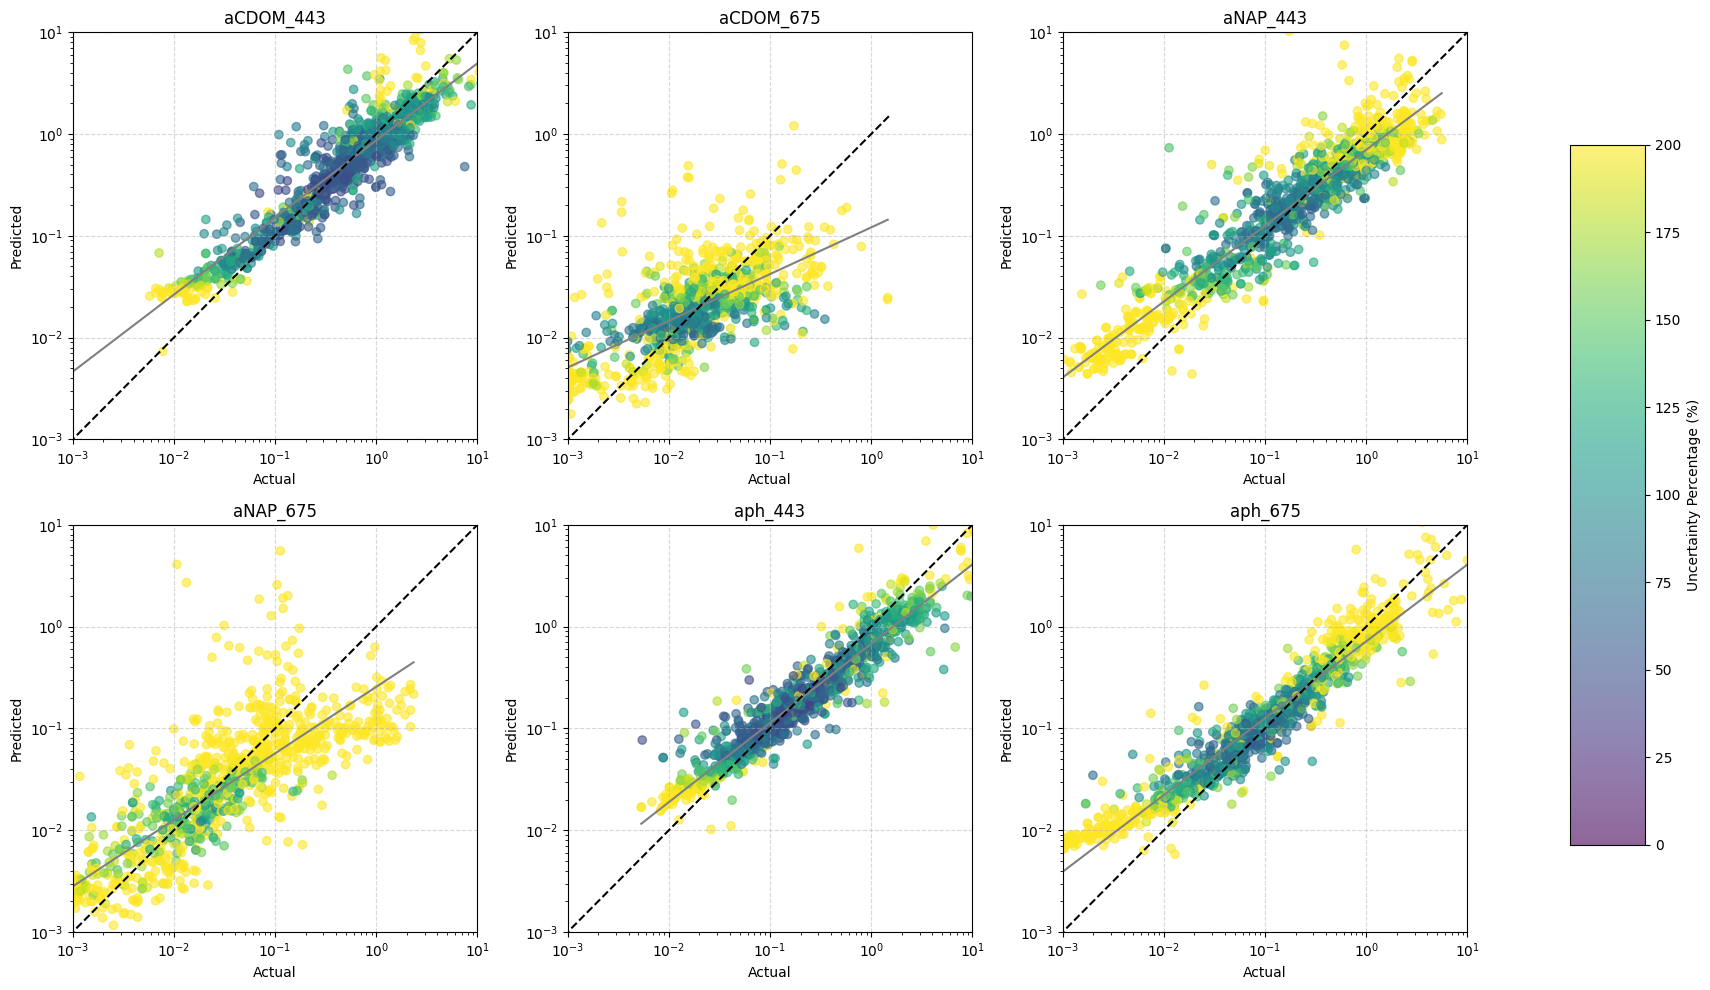

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(alea_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epi_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


In [23]:
metrics_df

obs_cor         MAPD       MAD       sspb        mdsa
aCDOM_443     1160   263.286607  0.516064  -0.203709   30.909137
aCDOM_675     1160  1657.878335  1.458989  18.839587   86.775734
aNAP_443      1160   106.770307  0.852552   6.533341   67.236157
aNAP_675      1160   263.624870  1.653735  16.839255  123.622492
aph_443       1160    47.389405  0.530287  -9.877159   38.338636
aph_675       1160    89.697105  0.677200  14.903125   43.268847

In [24]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


In [52]:
def custom_mdn_loss(num_components, num_targets, epsilon=1e-6):
    """

    The loss function computes the negative log likelihood of the true data given the predicted mixture distribution,
    which consists of a specified number of multivariate normal components. The NN outputs are split into
    mixing coefficients, means, and Cholesky decomposition parameters for the covariance matrices.

    Args:
        num_components (int): The number of mixture components (e.g., the number of Gaussian distributions in the mixture).
        num_targets (int): The dimensionality of the target space (e.g., the number of variables being predicted).
        epsilon (float, optional): Small value to ensure stability when constructing covariance matrices.
                                   Default is 1e-6.

    Returns:
        function: A loss function that can be used in model compilation.

    The returned loss function operates as follows:

    1. Splits the predicted values (`y_pred`) into mixing coefficients (`pi`), means (`mu`), and Cholesky decomposition
       parameters (`chol_params`).
    2. Applies a softmax function to the mixing coefficients to ensure they sum to 1.
    3. Reshapes the means and Cholesky decomposition parameters to the appropriate dimensions.
    4. Constructs the Cholesky lower triangular matrices from the Cholesky parameters.
    5. Adds `epsilon` to the diagonal elements of the Cholesky matrices to ensure positive definiteness.
    6. Defines a mixture of multivariate normal distributions using the reshaped parameters.
    7. Computes and returns the negative log likelihood of the true y given the mixture distribution (mix).

    Note:
          `num_components * (1 + num_targets + num_targets * (num_targets + 1) // 2)`.
    """
    def loss(y_true, y_pred):
        # Split y_pred into its components: mixing coefficients (pi), means (mu), and Cholesky decomposition parameters (chol_params)
        split_sizes = [num_components, num_components * num_targets, num_components * num_targets * (num_targets + 1) // 2]
        pi, mu, chol_params = tf.split(y_pred, num_or_size_splits=split_sizes, axis=-1)
        pi = tf.nn.softmax(pi, axis=-1)  # Softmax to get mixing coefficients

        # Reshape mu and chol_params to match the desired dimensions
        mu = tf.reshape(mu, [-1, num_components, num_targets])
        chol_params = tf.reshape(chol_params, [-1, num_components, num_targets * (num_targets + 1) // 2])

        # Create covariance matrices from the Cholesky parameters
        chol_matrices = tfp.math.fill_triangular(chol_params)
        # Ensure positive definiteness of covariance matrices
        chol_matrices += epsilon * tf.linalg.eye(num_targets, batch_shape=[tf.shape(y_pred)[0], num_components])

        # Define the mixture of Multivariate Normal distributions
        components = tfp.distributions.MultivariateNormalTriL(loc=mu, scale_tril=chol_matrices)
        mixture = tfp.distributions.Categorical(probs=pi)
        mix = tfp.distributions.MixtureSameFamily(mixture_distribution=mixture, components_distribution=components)

        # Use mix: compute the log likelihood of the data given the model
        likelihood = mix.log_prob(y_true)

        # Return the negative log likelihood as the loss
        return -tf.reduce_mean(likelihood)

    return loss

def build_mdn_wavelength_specific(input_shape, n_mix=5, hidden=[100, 100, 100, 100, 100], lr=1e-3, l2_reg=1e-3, activation='relu', num_targets=6):

    """
    Build the MDN.

    Args:
        input_shape (int): The shape of the input data.
        n_mix (int): The number of mixture components (default is 5).
        hidden (list): A list of integers specifying the number of units in each hidden layer (default is [100, 100, 100, 100, 100]).
        lr (float): The learning rate for the optimizer (default is 1e-3).
        l2_reg (float): The L2 regularization factor (default is 1e-3).
        activation (str): The activation function to use in the hidden layers (default is 'relu').
        num_targets (int): The dimensionality of the target space (default is 6).

    Returns:
        Model: ready for training.
    """
    inputs = Input(shape=(input_shape,))
    x = inputs
    for units in hidden:
        x = Dense(units, activation=activation, kernel_regularizer=l2(l2_reg))(x)
    pi = Dense(n_mix, activation='softmax', name='pi')(x)
    mu = Dense(n_mix * num_targets, activation=None, name='mu')(x)

    # Calculate the size for Cholesky decomposition parameters
    chol_size = n_mix * num_targets * (num_targets + 1) // 2
    chol_params = Dense(chol_size, activation=None, name='chol')(x)

    outputs = Concatenate(axis=-1)([pi, mu, chol_params])

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Pass the correct parameters to the custom MDN loss function
    mdn_loss = custom_mdn_loss(n_mix, num_targets)
    model.compile(optimizer=optimizer, loss=mdn_loss)
    return model

def train_mdn(model, X_train, y_train, epochs=100, batch_size=32):
    """
    Train the MDN.

    Args:
        model (Model): The MDN model to be trained.
        X_train (np.ndarray): The training input data.
        y_train (np.ndarray): The training target data.
        epochs (int): The number of epochs to train the model (default is 100).
        batch_size (int): The size of the training batches (default is 32).

    Returns:
        Model, training history.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    # Fit the model with a validation split of 10%
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])

    return model, history

def split_mdn_outputs(raw_predictions, num_components, num_targets):
    """
    Split the raw prdictions into pi, mu and chol parameters.

    Args:
        raw_predictions (tf.Tensor): The raw output from the MDN model, with shape [batch_size, num_components * (1 + num_targets + num_targets * (num_targets + 1) // 2)].
        num_components (int): The number of mixture components (i.e., the number of Gaussian distributions in the mixture).
        num_targets (int): The dimensionality of the target space.

    Returns:
        pi (tf.Tensor): The mixing coefficients for each component, with shape [batch_size, num_components].
        mu (tf.Tensor): The means of the Gaussian components, with shape [batch_size, num_components, num_targets].
        chol_params (tf.Tensor): The Cholesky decomposition parameters for the covariance matrices of the Gaussian components, with shape [batch_size, num_components, num_targets * (num_targets + 1) // 2].

    The function operates as follows:

    1. Splits the `raw_predictions` tensor into three parts:
       - `pi`: Mixing coefficients of shape [batch_size, num_components].
       - `mu`: Means of shape [batch_size, num_components * num_targets].
       - `chol_params`: Cholesky decomposition parameters of shape [batch_size, num_components * num_targets * (num_targets + 1) // 2].
    2. Applies a softmax function to `pi` to ensure the mixing coefficients sum to 1.
    3. Reshapes `mu` to [batch_size, num_components, num_targets].
    4. Reshapes `chol_params` to [batch_size, num_components, num_targets * (num_targets + 1) // 2].
    """
    split_sizes = [num_components, num_components * num_targets, num_components * num_targets * (num_targets + 1) // 2]
    pi, mu, chol_params = tf.split(raw_predictions, num_or_size_splits=split_sizes, axis=-1)
    pi = tf.nn.softmax(pi, axis=-1)  # Ensure mixing coefficients sum to 1
    return pi, mu, chol_params

def mdn_total_uncertainty(pi, mu, chol_params, num_components, num_targets, scaler_y):
    """
    Calculate the mean predictions, aleatoric variance, epistemic variance, and total variance for the MDN.

    Args:
        pi (tf.Tensor): Mixing coefficients of shape [batch_size, num_components].
        mu (tf.Tensor): Means of the mixture components of shape [batch_size, num_components * num_targets].
        chol_params (tf.Tensor): Cholesky decomposition parameters of shape [batch_size, num_components * num_targets * (num_targets + 1) // 2].
        num_components (int): The number of mixture components.
        num_targets (int): The dimensionality of the target space.
        scaler_y (sklearn.preprocessing.MinMaxScaler): Scaler used to transform the target variables.

    Returns:
        mean_predictions (np.ndarray): Mean predictions in the original space of shape [batch_size, num_targets].
        total_variance (np.ndarray): Total variance in the original space of shape.
        aleatoric_variance (np.ndarray): Aleatoric variance in the original space.
        epistemic_variance (np.ndarray): Epistemic variance in the original space.
        std_devs (np.ndarray): Standard deviations in the original space.
    """
    # Reshape pi and mu
    pi = tf.reshape(pi, [-1, num_components, 1])
    mu = tf.reshape(mu, [-1, num_components, num_targets])

    # Calculate the mean predictions (expected means)
    mean_predictions = tf.reduce_sum(pi * mu, axis=1)  # mean_predictions shape: [batch_size, num_targets]

    # Reshape chol_params and calculate Sigma
    chol_elements = num_targets * (num_targets + 1) // 2
    chol_matrices = tf.reshape(chol_params, [-1, num_components, chol_elements])
    L = tfp.math.fill_triangular(chol_matrices)
    Sigma = tf.matmul(L, L, transpose_b=True)  # [batch_size, num_components, num_targets, num_targets]

    # Aleatoric var
    variances = tf.linalg.diag_part(Sigma)  # [batch_size, num_components, num_targets]
    aleatoric_variance = tf.reduce_sum(pi * variances, axis=1)  # [batch_size, num_targets]

    # Epistemic var
    mu_weighted = pi * mu  # Weight means by their mixture probabilities
    mu_squared_weighted = pi * tf.square(mu)  # Weight squared means by their mixture probabilities
    expected_mu_squared = tf.reduce_sum(mu_squared_weighted, axis=1)  # [batch_size, num_targets]
    square_of_expected_mu = tf.square(tf.reduce_sum(mu_weighted, axis=1))  # [batch_size, num_targets]
    epistemic_variance = expected_mu_squared - square_of_expected_mu  # [batch_size, num_targets]

    # Total var
    total_variance = aleatoric_variance + epistemic_variance  # [batch_size, num_targets]
    ale_frac = aleatoric_variance / total_variance

    # Reshape mean predictions for inverse transformation
    original_shape = mean_predictions.shape
    mean_predictions_scaled = mean_predictions.numpy().reshape(-1, num_targets)

    # Convert means from scaled space to log space
    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions_log = mean_predictions_log.reshape(original_shape)

    # Calculate the scaling factor for variances
    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log->scaled scaling factor

    # Back-scale the variances
    aleatoric_variance = aleatoric_variance * (scaling_factor ** 2)
    epistemic_variance = epistemic_variance * (scaling_factor ** 2)
    #total_variance = total_variance * (scaling_factor ** 2)

    # Convert from log space to the original space
    mean_predictions = np.exp(mean_predictions_log)
    aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
    epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
    total_variance = aleatoric_variance + epistemic_variance
    # total_variance = np.exp(2 * mean_predictions_log + total_variance) * (np.exp(total_variance) - 1)
    # aleatoric_variance = ale_frac * total_variance
    # epistemic_variance = (1-ale_frac) * total_variance

    # Calculate standard deviations
    std_devs = np.sqrt(total_variance)

    return mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs

#mean_preds, total_var, alea_var, epi_var, std_devs = mdn_total_uncertainty(pi, mu, chol_params, 5, 6, scaler_y=scaler_y)

def calculate_metrics(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) and other metrics between true and predicted values.

    Args:
    - y_true: Actual values (numpy array).
    - y_pred: Predicted values (numpy array).

    Returns:
    - Tuple of metrics (obs_cor, MAPD, MAD, sspb, mdsa) for the predictions.
    """
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics assuming these functions are vectorized and can handle arrays
    mapd_values = mape(y_true, y_pred)
    mad_values = MAD(y_true, y_pred)
    sspb_values = sspb(y_true, y_pred)
    mdsa_values = mdsa(y_true, y_pred)

    # obs_cor is a scalar, all other values should be vectors of the same length as y_true/pred has columns
    obs_cor = len(y_pred)

    return obs_cor, mapd_values, mad_values, sspb_values, mdsa_values

# Calculate metrics for each target variable and store them in a DataFrame
def calculate_and_store_metrics(y_test, mean_preds, y_columns):
    # Initialize a dictionary to hold the metrics
    metrics_dict = {'obs_cor': []}
    # Initialize keys for each metric with empty lists
    for metric_name in ['MAPD', 'MAD', 'sspb', 'mdsa']:
        metrics_dict[metric_name] = []

    # Calculate metrics for each target variable
    for i in range(y_test.shape[1]):
        y_true = y_test[:, i]
        y_pred = mean_preds[:, i]
        obs_cor, mapd, mad, sspb, mdsa = calculate_metrics(y_true, y_pred)

        # Append the scalar metrics
        metrics_dict['obs_cor'].append(obs_cor)
        metrics_dict['MAPD'].append(mapd)  # Assuming mapd is a scalar
        metrics_dict['MAD'].append(mad)    # Assuming mad is a scalar
        metrics_dict['sspb'].append(sspb)  # Assuming sspb is a scalar
        metrics_dict['mdsa'].append(mdsa)  # Assuming mdsa is a scalar

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame(metrics_dict, index=y_columns)

    return metrics_df

def train_and_evaluate_models(X_train, y_train_scaled, X_test, y_test, y_columns, scaler_y,
                              input_shape, num_models=3, hidden_units=100, n_layers=5, dropout_rate=0.25,
                              l2_reg=1e-3, activation='relu', output_size=6,
                              epochs=1000, batch_size=32, learning_rate=0.001):

    all_models = []
    all_mdsa = []

    best_overall_model = None
    min_total_mdsa = float('inf')
    best_model_index = -1

    for i in range(num_models):
        model = build_mdn_wavelength_specific(
            input_shape=input_shape,
            n_mix=5,
            hidden=[hidden_units] * n_layers,
            lr=learning_rate,
            l2_reg=l2_reg,
            activation=activation,
            num_targets=output_size
        )
        
        model, history = train_mdn(model, X_train, y_train_scaled, epochs=epochs, batch_size=batch_size)

        print(f'Model {i+1}/{num_models}: Calculating mean predictions.')

        # Generate predictions
        raw_predictions = model.predict(X_test)

        n_mix = 5  # Number of mixture components
        num_targets = output_size  # Number of target variables

        pi, mu, chol_params = split_mdn_outputs(raw_predictions, n_mix, num_targets)

        mean_preds, total_var, alea_var, epi_var, std_devs = mdn_total_uncertainty(pi, mu, chol_params, n_mix, num_targets, scaler_y=scaler_y)

        print(f'Model {i+1}/{num_models}: Completed prediction with uncertainty.')

        # Calculate metrics
        metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)

        all_models.append(model)
        all_mdsa.append(metrics_df['mdsa'].values)

        total_mdsa = metrics_df.loc[['aCDOM_443', 'aNAP_443', 'aph_443'], 'mdsa'].sum()  # Sum the mdsa of the specified variables
        if total_mdsa < min_total_mdsa:
            min_total_mdsa = total_mdsa
            best_overall_model = model
            best_model_index = i

    mdsa_df = pd.DataFrame(all_mdsa, columns=y_columns)

    print(f'The best model index is: {best_model_index}')

    return best_overall_model, best_model_index, mdsa_df

# Main execution
# Select Rrs values in 5 nm steps
rrs_columns = [f'Rrs_{nm}' for nm in range(400, 701, 5)]
X_train = random_train_df[rrs_columns].values
X_test = random_test_df[rrs_columns].values

# Extracting target variables
y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
y_train = random_train_df[y_columns].values
y_test = random_test_df[y_columns].values

# Apply log transformation to the target variables
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Apply Min-Max scaling to log-transformed target variables
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_test_scaled = scaler_y.transform(y_test_log)

# Call the function to train and evaluate models
best_model, best_model_index, mdsa_df = train_and_evaluate_models(
    X_train, y_train_scaled, X_test, y_test, y_columns,
    scaler_y=scaler_y, input_shape=X_train.shape[1], num_models=10
)



Epoch 1/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 22.9934 - val_loss: 4.1058
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1551 - val_loss: 1.1820
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0156 - val_loss: -0.0187
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.1297 - val_loss: -0.6422
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3720 - val_loss: 0.2001
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268 - val_loss: -0.9825
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.0861 - val_loss: -1.4948
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.7717 - val_loss: -2.0836
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -2.0728 - val_loss: -2.3498
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -2.4598 - val_loss: -2.4789
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -2.6727 - val_loss: -2.6765
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━

C:\Users\werthemo\AppData\Local\Temp\ipykernel_8904\1346062051.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1820.4917 - val_loss: 15.9910
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.7530 - val_loss: 9.6096
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8409 - val_loss: 5.5600
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3590 - val_loss: 3.3847
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1432 - val_loss: 2.6158
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5333 - val_loss: 1.6878
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5193 - val_loss: 1.0295
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8808 - val_loss: 0.4275
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4732 - val_loss: -0.2246
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0947 - val_loss: -0.5403
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.5016 - val_loss: -1.0153
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

C:\Users\werthemo\AppData\Local\Temp\ipykernel_8904\1346062051.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1921.2109 - val_loss: 8.6651
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2018 - val_loss: 4.9282
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9591 - val_loss: 2.6551
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6111 - val_loss: 1.5101
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2931 - val_loss: 0.7544
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4979 - val_loss: 0.2317
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - val_loss: -0.1391
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.2603 - val_loss: -0.5989
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.7719 - val_loss: -0.6692
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.8621 - val_loss: -1.1990
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -1.2408 - val_loss: -1.2882
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

C:\Users\werthemo\AppData\Local\Temp\ipykernel_8904\1346062051.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_8904\1346062051.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_8904\1346062051.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_8904\1346062051.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4450.9678 - val_loss: 40.3494
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.2645 - val_loss: 16.3107
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.5499 - val_loss: 5.8709
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9201 - val_loss: 3.1762
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8619 - val_loss: 2.2136
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7589 - val_loss: 1.5289
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5887 - val_loss: 1.1887
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3010 - val_loss: 0.6362
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5950 - val_loss: 0.0252
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1550 - val_loss: -0.3749
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.5051 - val_loss: -0.9406
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

In [29]:
mdsa_df

aCDOM_443   aCDOM_675    aNAP_443    aNAP_675    aph_443     aph_675
0  31.515161   77.381406   54.743615   93.971471  29.867566   35.128569
1  77.309624  148.887742  131.676441  237.145643  57.416509  100.205146
2  50.898852  120.036883   73.868961   97.838539  43.957675   50.501633
3  38.035274   85.547959   55.840131  107.055443  32.622140   42.540000
4  39.736803  107.359973   68.759921  136.405889  45.368717   59.700686
5  45.929560   86.423408   67.918649  115.221936  40.230826   51.190588
6  49.474729   96.782539   60.038593   92.112918  46.077611   53.382326
7  35.295711   82.410557   51.660840  114.600263  35.029593   36.652362
8  55.159365  135.462014   91.295935  149.202122  50.558083   64.917615
9  53.432439  112.911240  104.739932  150.429052  56.027737   60.002088

In [30]:
mdsa_df.std()

aCDOM_443    13.141875
aCDOM_675    24.063284
aNAP_443     25.792914
aNAP_675     43.529700
aph_443       9.409906
aph_675      18.593084
dtype: float64

In [32]:
file_path ='C:/SwitchDrive/Data/org_iop_model_predictions/mdn_random_mdsa_df_10_networks.csv'
mdsa_df.to_csv(file_path, index=False)

In [34]:
# import os

file_path ='C:/SwitchDrive/Data/org_iop_model_predictions/mdn_random_mdsa_df_10_networks.csv'
mdsa_df.to_csv(file_path, index=False)

# # Ensure the folder path exists
# folder_path = 'C:/SwitchDrive/Data/org_best_models/'
# os.makedirs(folder_path, exist_ok=True)

# # Save the best model in the TensorFlow SavedModel format
# best_model_path = os.path.join(folder_path, 'mdn_random_split_best.keras')
# best_model.save(best_model_path)

# print(f"Best model saved at: {best_model_path}")


Best model saved at: C:/SwitchDrive/Data/org_best_models/mdn_random_split_best.keras


In [54]:
# import os

# # Ensure the folder path exists
# folder_path = 'C:/SwitchDrive/Data/org_best_models/'
# os.makedirs(folder_path, exist_ok=True)

# # Save the best model in the TensorFlow SavedModel format
# best_model_path = os.path.join(folder_path, 'mdn_random_split_best.keras')
# best_model.save(best_model_path)

# print(f"Best model saved at: {best_model_path}")

# Load the best model from the specified path
loaded_model_path = os.path.join(folder_path, 'mdn_random_split_best.keras')
loaded_model = tf.keras.models.load_model(loaded_model_path, custom_objects={'custom_mdn_loss': custom_mdn_loss})

print(f"Model loaded from: {loaded_model_path}")


Model loaded from: C:/SwitchDrive/Data/org_best_models/mdn_random_split_best.keras


In [55]:
# Generate predictions
raw_predictions = loaded_model.predict(X_test)

n_mix = 5  # Number of mixture components
num_targets = 6  # Number of target variables

pi, mu, chol_params = split_mdn_outputs(raw_predictions, n_mix, num_targets)

mean_preds, total_var, alea_var, epi_var, std_devs = mdn_total_uncertainty(pi, mu, chol_params, n_mix, num_targets, scaler_y=scaler_y)
metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [56]:
metrics_df

obs_cor         MAPD       MAD      sspb       mdsa
aCDOM_443     1160   487.015422  0.488210 -4.266561  31.515161
aCDOM_675     1160  2822.293348  1.227826  6.533627  77.381406
aNAP_443      1160    71.312131  0.713570 -7.756621  54.743615
aNAP_675      1160   163.273247  1.258460  1.099019  93.971471
aph_443       1160    41.871123  0.437687 -6.602917  29.867566
aph_675       1160    50.839594  0.477165 -0.539505  35.128569

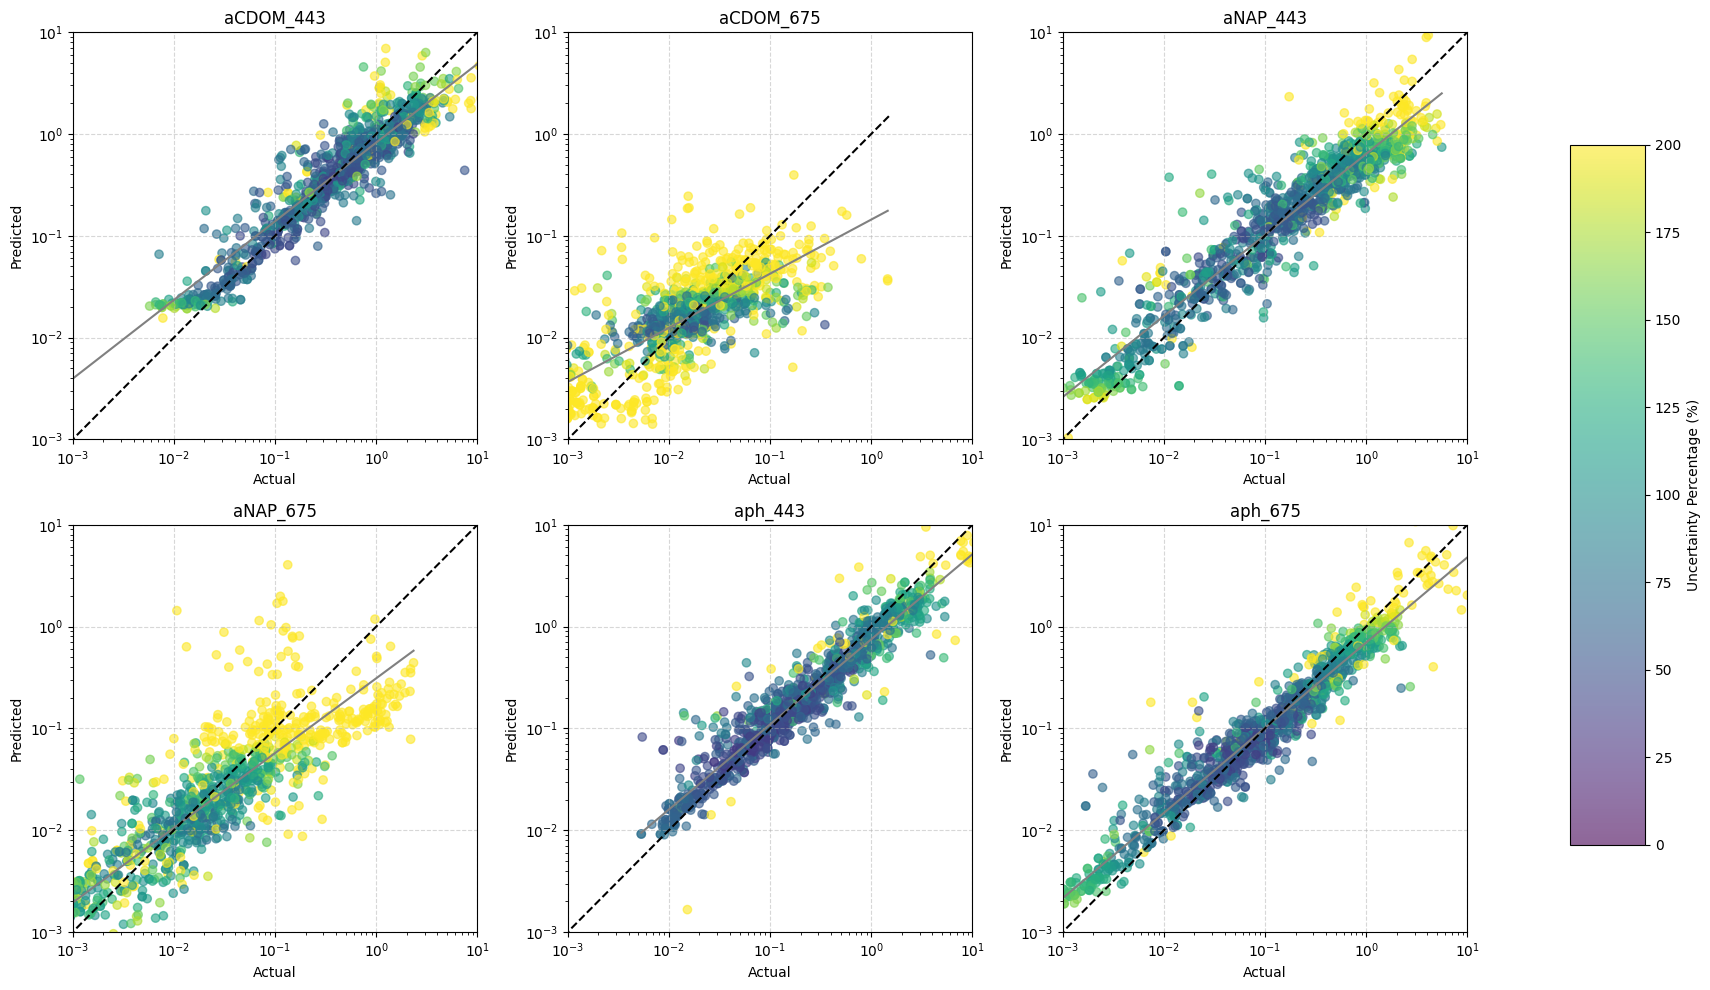

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(alea_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epi_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


In [58]:
metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)


from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    y_test,
    mean_preds,
    total_var,
    alea_var,
    epi_var,
    std_devs
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=y_columns)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [1160, 1160, 1160, 1160, 1160, 1160])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(1160)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=y_columns)

final_df_multi_indexed_corrected

#save

file_path ='C:/SwitchDrive/Data/org_iop_model_predictions/mdn_random_split_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)


# WD

In [48]:
def custom_mdn_loss(num_components, num_targets, epsilon=1e-6):
    """

    The loss function computes the negative log likelihood of the true data given the predicted mixture distribution,
    which consists of a specified number of multivariate normal components. The NN outputs are split into
    mixing coefficients, means, and Cholesky decomposition parameters for the covariance matrices.

    Args:
        num_components (int): The number of mixture components (e.g., the number of Gaussian distributions in the mixture).
        num_targets (int): The dimensionality of the target space (e.g., the number of variables being predicted).
        epsilon (float, optional): Small value to ensure stability when constructing covariance matrices.
                                   Default is 1e-6.

    Returns:
        function: A loss function that can be used in model compilation.

    The returned loss function operates as follows:

    1. Splits the predicted values (`y_pred`) into mixing coefficients (`pi`), means (`mu`), and Cholesky decomposition
       parameters (`chol_params`).
    2. Applies a softmax function to the mixing coefficients to ensure they sum to 1.
    3. Reshapes the means and Cholesky decomposition parameters to the appropriate dimensions.
    4. Constructs the Cholesky lower triangular matrices from the Cholesky parameters.
    5. Adds `epsilon` to the diagonal elements of the Cholesky matrices to ensure positive definiteness.
    6. Defines a mixture of multivariate normal distributions using the reshaped parameters.
    7. Computes and returns the negative log likelihood of the true y given the mixture distribution (mix).

    Note:
          `num_components * (1 + num_targets + num_targets * (num_targets + 1) // 2)`.
    """
    def loss(y_true, y_pred):
        # Split y_pred into its components: mixing coefficients (pi), means (mu), and Cholesky decomposition parameters (chol_params)
        split_sizes = [num_components, num_components * num_targets, num_components * num_targets * (num_targets + 1) // 2]
        pi, mu, chol_params = tf.split(y_pred, num_or_size_splits=split_sizes, axis=-1)
        pi = tf.nn.softmax(pi, axis=-1)  # Softmax to get mixing coefficients

        # Reshape mu and chol_params to match the desired dimensions
        mu = tf.reshape(mu, [-1, num_components, num_targets])
        chol_params = tf.reshape(chol_params, [-1, num_components, num_targets * (num_targets + 1) // 2])

        # Create covariance matrices from the Cholesky parameters
        chol_matrices = tfp.math.fill_triangular(chol_params)
        # Ensure positive definiteness of covariance matrices
        chol_matrices += epsilon * tf.linalg.eye(num_targets, batch_shape=[tf.shape(y_pred)[0], num_components])

        # Define the mixture of Multivariate Normal distributions
        components = tfp.distributions.MultivariateNormalTriL(loc=mu, scale_tril=chol_matrices)
        mixture = tfp.distributions.Categorical(probs=pi)
        mix = tfp.distributions.MixtureSameFamily(mixture_distribution=mixture, components_distribution=components)

        # Use mix: compute the log likelihood of the data given the model
        likelihood = mix.log_prob(y_true)

        # Return the negative log likelihood as the loss
        return -tf.reduce_mean(likelihood)

    return loss

def build_mdn_wavelength_specific(input_shape, n_mix=5, hidden=[100, 100, 100, 100, 100], lr=1e-3, l2_reg=1e-3, activation='relu', num_targets=6):

    """
    Build the MDN.

    Args:
        input_shape (int): The shape of the input data.
        n_mix (int): The number of mixture components (default is 5).
        hidden (list): A list of integers specifying the number of units in each hidden layer (default is [100, 100, 100, 100, 100]).
        lr (float): The learning rate for the optimizer (default is 1e-3).
        l2_reg (float): The L2 regularization factor (default is 1e-3).
        activation (str): The activation function to use in the hidden layers (default is 'relu').
        num_targets (int): The dimensionality of the target space (default is 6).

    Returns:
        Model: ready for training.
    """
    inputs = Input(shape=(input_shape,))
    x = inputs
    for units in hidden:
        x = Dense(units, activation=activation, kernel_regularizer=l2(l2_reg))(x)
    pi = Dense(n_mix, activation='softmax', name='pi')(x)
    mu = Dense(n_mix * num_targets, activation=None, name='mu')(x)

    # Calculate the size for Cholesky decomposition parameters
    chol_size = n_mix * num_targets * (num_targets + 1) // 2
    chol_params = Dense(chol_size, activation=None, name='chol')(x)

    outputs = Concatenate(axis=-1)([pi, mu, chol_params])

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Pass the correct parameters to the custom MDN loss function
    mdn_loss = custom_mdn_loss(n_mix, num_targets)
    model.compile(optimizer=optimizer, loss=mdn_loss)
    return model

def train_mdn(model, X_train, y_train, epochs=100, batch_size=32):
    """
    Train the MDN.

    Args:
        model (Model): The MDN model to be trained.
        X_train (np.ndarray): The training input data.
        y_train (np.ndarray): The training target data.
        epochs (int): The number of epochs to train the model (default is 100).
        batch_size (int): The size of the training batches (default is 32).

    Returns:
        Model, training history.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    # Fit the model with a validation split of 10%
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])

    return model, history

def split_mdn_outputs(raw_predictions, num_components, num_targets):
    """
    Split the raw prdictions into pi, mu and chol parameters.

    Args:
        raw_predictions (tf.Tensor): The raw output from the MDN model, with shape [batch_size, num_components * (1 + num_targets + num_targets * (num_targets + 1) // 2)].
        num_components (int): The number of mixture components (i.e., the number of Gaussian distributions in the mixture).
        num_targets (int): The dimensionality of the target space.

    Returns:
        pi (tf.Tensor): The mixing coefficients for each component, with shape [batch_size, num_components].
        mu (tf.Tensor): The means of the Gaussian components, with shape [batch_size, num_components, num_targets].
        chol_params (tf.Tensor): The Cholesky decomposition parameters for the covariance matrices of the Gaussian components, with shape [batch_size, num_components, num_targets * (num_targets + 1) // 2].

    The function operates as follows:

    1. Splits the `raw_predictions` tensor into three parts:
       - `pi`: Mixing coefficients of shape [batch_size, num_components].
       - `mu`: Means of shape [batch_size, num_components * num_targets].
       - `chol_params`: Cholesky decomposition parameters of shape [batch_size, num_components * num_targets * (num_targets + 1) // 2].
    2. Applies a softmax function to `pi` to ensure the mixing coefficients sum to 1.
    3. Reshapes `mu` to [batch_size, num_components, num_targets].
    4. Reshapes `chol_params` to [batch_size, num_components, num_targets * (num_targets + 1) // 2].
    """
    split_sizes = [num_components, num_components * num_targets, num_components * num_targets * (num_targets + 1) // 2]
    pi, mu, chol_params = tf.split(raw_predictions, num_or_size_splits=split_sizes, axis=-1)
    pi = tf.nn.softmax(pi, axis=-1)  # Ensure mixing coefficients sum to 1
    return pi, mu, chol_params

def mdn_total_uncertainty(pi, mu, chol_params, num_components, num_targets, scaler_y):
    """
    Calculate the mean predictions, aleatoric variance, epistemic variance, and total variance for the MDN.

    Args:
        pi (tf.Tensor): Mixing coefficients of shape [batch_size, num_components].
        mu (tf.Tensor): Means of the mixture components of shape [batch_size, num_components * num_targets].
        chol_params (tf.Tensor): Cholesky decomposition parameters of shape [batch_size, num_components * num_targets * (num_targets + 1) // 2].
        num_components (int): The number of mixture components.
        num_targets (int): The dimensionality of the target space.
        scaler_y (sklearn.preprocessing.MinMaxScaler): Scaler used to transform the target variables.

    Returns:
        mean_predictions (np.ndarray): Mean predictions in the original space of shape [batch_size, num_targets].
        total_variance (np.ndarray): Total variance in the original space of shape.
        aleatoric_variance (np.ndarray): Aleatoric variance in the original space.
        epistemic_variance (np.ndarray): Epistemic variance in the original space.
        std_devs (np.ndarray): Standard deviations in the original space.
    """
    # Reshape pi and mu
    pi = tf.reshape(pi, [-1, num_components, 1])
    mu = tf.reshape(mu, [-1, num_components, num_targets])

    # Calculate the mean predictions (expected means)
    mean_predictions = tf.reduce_sum(pi * mu, axis=1)  # mean_predictions shape: [batch_size, num_targets]

    # Reshape chol_params and calculate Sigma
    chol_elements = num_targets * (num_targets + 1) // 2
    chol_matrices = tf.reshape(chol_params, [-1, num_components, chol_elements])
    L = tfp.math.fill_triangular(chol_matrices)
    Sigma = tf.matmul(L, L, transpose_b=True)  # [batch_size, num_components, num_targets, num_targets]

    # Aleatoric var
    variances = tf.linalg.diag_part(Sigma)  # [batch_size, num_components, num_targets]
    aleatoric_variance = tf.reduce_sum(pi * variances, axis=1)  # [batch_size, num_targets]

    # Epistemic var
    mu_weighted = pi * mu  # Weight means by their mixture probabilities
    mu_squared_weighted = pi * tf.square(mu)  # Weight squared means by their mixture probabilities
    expected_mu_squared = tf.reduce_sum(mu_squared_weighted, axis=1)  # [batch_size, num_targets]
    square_of_expected_mu = tf.square(tf.reduce_sum(mu_weighted, axis=1))  # [batch_size, num_targets]
    epistemic_variance = expected_mu_squared - square_of_expected_mu  # [batch_size, num_targets]

    # Total var
    total_variance = aleatoric_variance + epistemic_variance  # [batch_size, num_targets]
    ale_frac = aleatoric_variance / total_variance

    # Reshape mean predictions for inverse transformation
    original_shape = mean_predictions.shape
    mean_predictions_scaled = mean_predictions.numpy().reshape(-1, num_targets)

    # Convert means from scaled space to log space
    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions_log = mean_predictions_log.reshape(original_shape)

    # Calculate the scaling factor for variances
    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log->scaled scaling factor

    # Back-scale the variances
    aleatoric_variance = aleatoric_variance * (scaling_factor ** 2)
    epistemic_variance = epistemic_variance * (scaling_factor ** 2)
    #total_variance = total_variance * (scaling_factor ** 2)

    # Convert from log space to the original space
    mean_predictions = np.exp(mean_predictions_log)
    aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
    epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
    total_variance = aleatoric_variance + epistemic_variance
    # total_variance = np.exp(2 * mean_predictions_log + total_variance) * (np.exp(total_variance) - 1)
    # aleatoric_variance = ale_frac * total_variance
    # epistemic_variance = (1-ale_frac) * total_variance

    # Calculate standard deviations
    std_devs = np.sqrt(total_variance)

    return mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs

#mean_preds, total_var, alea_var, epi_var, std_devs = mdn_total_uncertainty(pi, mu, chol_params, 5, 6, scaler_y=scaler_y)

def calculate_metrics(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) and other metrics between true and predicted values.

    Args:
    - y_true: Actual values (numpy array).
    - y_pred: Predicted values (numpy array).

    Returns:
    - Tuple of metrics (obs_cor, MAPD, MAD, sspb, mdsa) for the predictions.
    """
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics assuming these functions are vectorized and can handle arrays
    mapd_values = mape(y_true, y_pred)
    mad_values = MAD(y_true, y_pred)
    sspb_values = sspb(y_true, y_pred)
    mdsa_values = mdsa(y_true, y_pred)

    # obs_cor is a scalar, all other values should be vectors of the same length as y_true/pred has columns
    obs_cor = len(y_pred)

    return obs_cor, mapd_values, mad_values, sspb_values, mdsa_values

# Calculate metrics for each target variable and store them in a DataFrame
def calculate_and_store_metrics(y_test, mean_preds, y_columns):
    # Initialize a dictionary to hold the metrics
    metrics_dict = {'obs_cor': []}
    # Initialize keys for each metric with empty lists
    for metric_name in ['MAPD', 'MAD', 'sspb', 'mdsa']:
        metrics_dict[metric_name] = []

    # Calculate metrics for each target variable
    for i in range(y_test.shape[1]):
        y_true = y_test[:, i]
        y_pred = mean_preds[:, i]
        obs_cor, mapd, mad, sspb, mdsa = calculate_metrics(y_true, y_pred)

        # Append the scalar metrics
        metrics_dict['obs_cor'].append(obs_cor)
        metrics_dict['MAPD'].append(mapd)  # Assuming mapd is a scalar
        metrics_dict['MAD'].append(mad)    # Assuming mad is a scalar
        metrics_dict['sspb'].append(sspb)  # Assuming sspb is a scalar
        metrics_dict['mdsa'].append(mdsa)  # Assuming mdsa is a scalar

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame(metrics_dict, index=y_columns)

    return metrics_df

def train_and_evaluate_models(X_train, y_train_scaled, X_test, y_test, y_columns, scaler_y,
                              input_shape, num_models=10, hidden_units=100, n_layers=5, dropout_rate=0.25,
                              l2_reg=1e-3, activation='relu', output_size=6,
                              epochs=1000, batch_size=32, learning_rate=0.001):

    all_models = []
    all_mdsa = []

    best_overall_model = None
    min_total_mdsa = float('inf')
    best_model_index = -1

    for i in range(num_models):
        model = build_mdn_wavelength_specific(
            input_shape=input_shape,
            n_mix=5,
            hidden=[hidden_units] * n_layers,
            lr=learning_rate,
            l2_reg=l2_reg,
            activation=activation,
            num_targets=output_size
        )
        
        model, history = train_mdn(model, X_train, y_train_scaled, epochs=epochs, batch_size=batch_size)

        print(f'Model {i+1}/{num_models}: Calculating mean predictions.')

        # Generate predictions
        raw_predictions = model.predict(X_test)

        n_mix = 5  # Number of mixture components
        num_targets = output_size  # Number of target variables

        pi, mu, chol_params = split_mdn_outputs(raw_predictions, n_mix, num_targets)

        mean_preds, total_var, alea_var, epi_var, std_devs = mdn_total_uncertainty(pi, mu, chol_params, n_mix, num_targets, scaler_y=scaler_y)

        print(f'Model {i+1}/{num_models}: Completed prediction with uncertainty.')

        # Calculate metrics
        metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)

        all_models.append(model)
        all_mdsa.append(metrics_df['mdsa'].values)

        total_mdsa = metrics_df.loc[['aCDOM_443', 'aNAP_443', 'aph_443'], 'mdsa'].sum()  # Sum the mdsa of the specified variables
        if total_mdsa < min_total_mdsa:
            min_total_mdsa = total_mdsa
            best_overall_model = model
            best_model_index = i

    mdsa_df = pd.DataFrame(all_mdsa, columns=y_columns)

    print(f'The best model index is: {best_model_index}')

    return best_overall_model, best_model_index, mdsa_df

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extracting Rrs_ values as inputs
wd_X_train = wd_train_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]
wd_X_test = wd_test_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]

# Extracting target variables
y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
#y_columns = ['aCDOM_443', 'aNAP_443', 'aph_443']

wd_y_train = wd_train_df[y_columns].values
wd_y_test = wd_test_df[y_columns].values

# Apply log transformation to the target variables
wd_y_train_log = np.log(wd_y_train)
wd_y_test_log = np.log(wd_y_test)

# Apply Min-Max scaling to log-transformed target variables
wd_scaler_y = MinMaxScaler(feature_range=(-1, 1))
wd_y_train_scaled = wd_scaler_y.fit_transform(wd_y_train_log)
wd_y_test_scaled = wd_scaler_y.transform(wd_y_test_log)

# Call the function to train and evaluate models
wd_best_model, wd_best_model_index, wd_mdsa_df = train_and_evaluate_models(
    wd_X_train, wd_y_train_scaled, wd_X_test, wd_y_test, y_columns,
    scaler_y=wd_scaler_y, input_shape=wd_X_train.shape[1], num_models=10
)



Epoch 1/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 385.8243 - val_loss: 8.2683
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0707 - val_loss: 6.7308
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1981 - val_loss: 5.8184
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3204 - val_loss: 4.8494
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6062 - val_loss: 3.4652
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2843 - val_loss: 3.9128
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3777 - val_loss: 2.7194
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.2826 - val_loss: 3.1413
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.7406 - val_loss: 2.0229
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -1.1794 - val_loss: 1.4107
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -1.4092 - val_loss: 1.3061
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4

C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2890.1423 - val_loss: 22.4439
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.7910 - val_loss: 9.3304
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6183 - val_loss: 5.0029
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4667 - val_loss: 3.8520
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5106 - val_loss: 3.1018
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3432 - val_loss: 2.3790
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4738 - val_loss: 2.2336
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0935 - val_loss: 2.0707
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.4724 - val_loss: 1.6022
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.9924 - val_loss: 1.5297
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -1.1978 - val_loss: 1.3184
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1838.3241 - val_loss: 31.6736
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34.5585 - val_loss: 12.2522
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.7298 - val_loss: 7.0890
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.2172 - val_loss: 5.9049
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8700 - val_loss: 4.1909
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0128 - val_loss: 4.1932
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2132 - val_loss: 3.4843
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2813 - val_loss: 3.0952
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7346 - val_loss: 2.9344
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1245 - val_loss: 2.9519
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6065 - val_loss: 2.6846
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - l

C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1300.6926 - val_loss: 7.0423
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2673 - val_loss: 5.6056
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3065 - val_loss: 4.7990
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8439 - val_loss: 3.7594
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5570 - val_loss: 2.7189
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.1545 - val_loss: 2.2579
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.2218 - val_loss: 2.2934
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -0.6704 - val_loss: 1.8128
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -1.1898 - val_loss: 2.2877
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -1.3604 - val_loss: 2.2570
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -1.3310 - val_loss: 2.1642
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


Epoch 1/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1900.7245 - val_loss: 12.7228
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.1894 - val_loss: 7.3574
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5474 - val_loss: 4.4855
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9728 - val_loss: 3.6135
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9078 - val_loss: 2.8547
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0686 - val_loss: 2.6494
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1897 - val_loss: 2.6092
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0528 - val_loss: 2.5864
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.6205 - val_loss: 2.3965
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -1.0333 - val_loss: 2.8635
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -1.4944 - val_loss: 2.7136
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0

C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7881.1362 - val_loss: 20.5483
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26.6410 - val_loss: 13.1258
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.7666 - val_loss: 9.8861
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7836 - val_loss: 7.8511
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5983 - val_loss: 6.7334
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4407 - val_loss: 5.8985
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6047 - val_loss: 4.9608
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0810 - val_loss: 4.3103
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3917 - val_loss: 3.9630
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9027 - val_loss: 3.2774
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3096 - val_loss: 3.3418
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - lo

C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 332.3786 - val_loss: 5.4311
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1569 - val_loss: 4.6651
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8849 - val_loss: 4.1880
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6171 - val_loss: 3.2278
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3666 - val_loss: 2.6595
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -0.2478 - val_loss: 2.3036
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.5809 - val_loss: 2.1586
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -1.2835 - val_loss: 2.3807
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -1.9032 - val_loss: 2.3765
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -2.2026 - val_loss: 1.9035
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -2.5384 - val_loss: 2.5344
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - l

C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 17680.7207 - val_loss: 29.9454
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 74.1648 - val_loss: 20.7048
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41.3378 - val_loss: 13.5713
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.0490 - val_loss: 8.5356
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0090 - val_loss: 5.1405
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1687 - val_loss: 4.1551
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1826 - val_loss: 3.7701
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3395 - val_loss: 3.2328
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6007 - val_loss: 2.4615
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -0.0413 - val_loss: 1.9930
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -0.5159 - val_loss: 1.8327
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 992.9271 - val_loss: 9.1260
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5692 - val_loss: 7.7355
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6686 - val_loss: 6.2038
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4451 - val_loss: 5.5000
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4127 - val_loss: 3.7527
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3887 - val_loss: 4.0037
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.4485 - val_loss: 2.7289
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.4304 - val_loss: 3.4055
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -1.1069 - val_loss: 2.0826
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -1.1810 - val_loss: 2.3845
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -1.6145 - val_loss: 4.1672
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - lo

C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7191.1719 - val_loss: 20.5814
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27.7489 - val_loss: 8.6331
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.1342 - val_loss: 5.1730
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4698 - val_loss: 4.5855
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7375 - val_loss: 3.8878
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9105 - val_loss: 3.0741
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6836 - val_loss: 2.8665
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4401 - val_loss: 2.4190
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -0.3403 - val_loss: 1.7626
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.9768 - val_loss: 1.4234
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -1.4423 - val_loss: 1.1699
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - 

C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


In [49]:
wd_mdsa_df

aCDOM_443   aCDOM_675    aNAP_443    aNAP_675     aph_443     aph_675
0  143.567900  271.104603  306.532017  328.183020  143.763397  207.360295
1  108.932799  238.574849  364.434523  496.004938  223.949328  298.230983
2   48.139199  155.154202  123.732663  159.286410   64.236038   73.401564
3   86.825476  170.312798  182.672307  259.316039  114.368772  142.990015
4  280.467056  280.138846  326.062922  450.074027  229.076226  314.220860
5  179.261381  209.091400  357.693941  535.363118  275.247398  363.857755
6  169.371785  266.388869  336.366816  481.634902  181.389996  272.445533
7  109.193008  206.979995  179.905649  262.395133  114.439326  147.886600
8  140.530099  592.543529  209.828049  257.933443  126.146371  186.536581
9  164.885616  317.437829  421.651900  679.685079  233.911114  326.973834

In [57]:
file_path ='C:/SwitchDrive/Data/org_iop_model_predictions/mdn_wd_mdsa_df_10_networks.csv'
wd_mdsa_df.to_csv(file_path, index=False)

wd_mdsa_df.std()

aCDOM_443     63.114051
aCDOM_675    123.913848
aNAP_443      98.916919
aNAP_675     161.978734
aph_443       68.041641
aph_675       95.449324
dtype: float64

In [52]:
#file_path ='C:/SwitchDrive/Data/org_iop_model_predictions/mdn_wd_mdsa_df_10_networks.csv'
#mdsa_df.to_csv(file_path, index=False)

wd_mdsa_df.std()

import os

# # Ensure the folder path exists
folder_path = 'C:/SwitchDrive/Data/org_best_models/'
os.makedirs(folder_path, exist_ok=True)

# Save the best model in the TensorFlow SavedModel format
wd_best_model_path = os.path.join(folder_path, 'mdn_wd_split_best.keras')
wd_best_model.save(wd_best_model_path)

print(f"Best model saved at: {wd_best_model_path}")

# Load the best model from the specified path
loaded_model_path = os.path.join(folder_path, 'mdn_wd_split_best.keras')
wd_loaded_model = tf.keras.models.load_model(loaded_model_path, custom_objects={'custom_mdn_loss': custom_mdn_loss})

print(f"Model loaded from: {loaded_model_path}")


Best model saved at: C:/SwitchDrive/Data/org_best_models/mdn_wd_split_best.keras
Model loaded from: C:/SwitchDrive/Data/org_best_models/mdn_wd_split_best.keras


In [53]:
# Generate predictions
raw_predictions = wd_loaded_model.predict(wd_X_test)

n_mix = 5  # Number of mixture components
num_targets = 6  # Number of target variables

pi, mu, chol_params = split_mdn_outputs(raw_predictions, n_mix, num_targets)

wd_mean_preds, wd_total_var, wd_alea_var, wd_epi_var, wd_std_devs = mdn_total_uncertainty(pi, mu, chol_params, n_mix, num_targets, scaler_y=wd_scaler_y)
wd_metrics_df = calculate_and_store_metrics(wd_y_test, wd_mean_preds, y_columns)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_11832\2347285801.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


In [54]:
wd_metrics_df

obs_cor        MAPD       MAD        sspb        mdsa
aCDOM_443     1160   85.232473  0.664063   -2.472766   48.139199
aCDOM_675     1160  197.389155  1.975289 -117.782234  155.154202
aNAP_443      1160   82.748424  1.383804  -75.450841  123.732663
aNAP_675      1160  164.148378  2.300463  -20.572340  159.286410
aph_443       1160   52.480871  0.852541  -30.687078   64.236038
aph_675       1160   72.566601  0.905775  -21.225784   73.401564

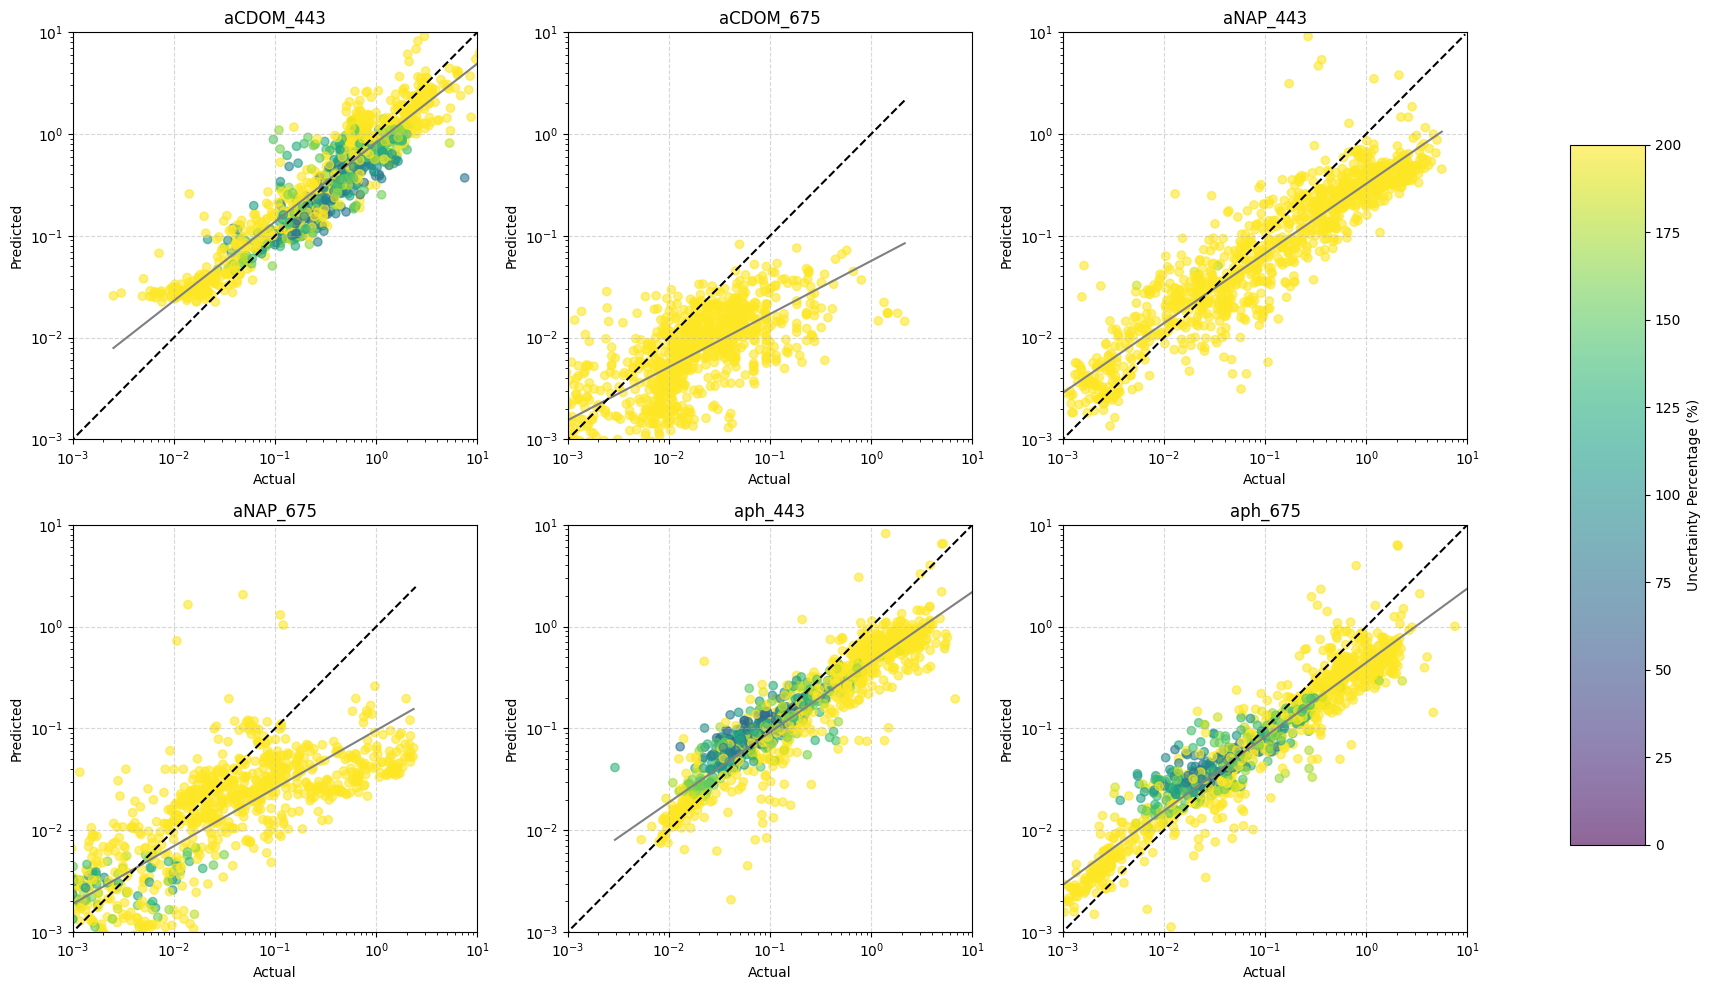

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
wd_percent_total_uncertainty = (np.sqrt(wd_total_var) / wd_mean_preds) * 100
wd_percent_aleatoric_uncertainty = (np.sqrt(wd_alea_var) / wd_mean_preds) * 100
wd_percent_epistemic_uncertainty = (np.sqrt(wd_epi_var) / wd_mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (wd_y_test > 1e-4) & (wd_mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = wd_y_test[:, i][mask[:, i]]
    y_values = wd_mean_preds[:, i][mask[:, i]]
    color_values = wd_percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')

    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


In [56]:
from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    wd_y_test,
    wd_mean_preds,
    wd_total_var,
    wd_alea_var,
    wd_epi_var,
    wd_std_devs
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=y_columns)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [1160, 1160, 1160, 1160, 1160, 1160])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(1160)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=y_columns)

final_df_multi_indexed_corrected

#save

file_path ='C:/SwitchDrive/Data/org_iop_model_predictions/mdn_wd_split_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)

# OOD

In [53]:
def custom_mdn_loss(num_components, num_targets, epsilon=1e-6):
    """

    The loss function computes the negative log likelihood of the true data given the predicted mixture distribution,
    which consists of a specified number of multivariate normal components. The NN outputs are split into
    mixing coefficients, means, and Cholesky decomposition parameters for the covariance matrices.

    Args:
        num_components (int): The number of mixture components (e.g., the number of Gaussian distributions in the mixture).
        num_targets (int): The dimensionality of the target space (e.g., the number of variables being predicted).
        epsilon (float, optional): Small value to ensure stability when constructing covariance matrices.
                                   Default is 1e-6.

    Returns:
        function: A loss function that can be used in model compilation.

    The returned loss function operates as follows:

    1. Splits the predicted values (`y_pred`) into mixing coefficients (`pi`), means (`mu`), and Cholesky decomposition
       parameters (`chol_params`).
    2. Applies a softmax function to the mixing coefficients to ensure they sum to 1.
    3. Reshapes the means and Cholesky decomposition parameters to the appropriate dimensions.
    4. Constructs the Cholesky lower triangular matrices from the Cholesky parameters.
    5. Adds `epsilon` to the diagonal elements of the Cholesky matrices to ensure positive definiteness.
    6. Defines a mixture of multivariate normal distributions using the reshaped parameters.
    7. Computes and returns the negative log likelihood of the true y given the mixture distribution (mix).

    Note:
          `num_components * (1 + num_targets + num_targets * (num_targets + 1) // 2)`.
    """
    def loss(y_true, y_pred):
        # Split y_pred into its components: mixing coefficients (pi), means (mu), and Cholesky decomposition parameters (chol_params)
        split_sizes = [num_components, num_components * num_targets, num_components * num_targets * (num_targets + 1) // 2]
        pi, mu, chol_params = tf.split(y_pred, num_or_size_splits=split_sizes, axis=-1)
        pi = tf.nn.softmax(pi, axis=-1)  # Softmax to get mixing coefficients

        # Reshape mu and chol_params to match the desired dimensions
        mu = tf.reshape(mu, [-1, num_components, num_targets])
        chol_params = tf.reshape(chol_params, [-1, num_components, num_targets * (num_targets + 1) // 2])

        # Create covariance matrices from the Cholesky parameters
        chol_matrices = tfp.math.fill_triangular(chol_params)
        # Ensure positive definiteness of covariance matrices
        chol_matrices += epsilon * tf.linalg.eye(num_targets, batch_shape=[tf.shape(y_pred)[0], num_components])

        # Define the mixture of Multivariate Normal distributions
        components = tfp.distributions.MultivariateNormalTriL(loc=mu, scale_tril=chol_matrices)
        mixture = tfp.distributions.Categorical(probs=pi)
        mix = tfp.distributions.MixtureSameFamily(mixture_distribution=mixture, components_distribution=components)

        # Use mix: compute the log likelihood of the data given the model
        likelihood = mix.log_prob(y_true)

        # Return the negative log likelihood as the loss
        return -tf.reduce_mean(likelihood)

    return loss

def build_mdn_wavelength_specific(input_shape, n_mix=5, hidden=[100, 100, 100, 100, 100], lr=1e-3, l2_reg=1e-3, activation='relu', num_targets=6):

    """
    Build the MDN.

    Args:
        input_shape (int): The shape of the input data.
        n_mix (int): The number of mixture components (default is 5).
        hidden (list): A list of integers specifying the number of units in each hidden layer (default is [100, 100, 100, 100, 100]).
        lr (float): The learning rate for the optimizer (default is 1e-3).
        l2_reg (float): The L2 regularization factor (default is 1e-3).
        activation (str): The activation function to use in the hidden layers (default is 'relu').
        num_targets (int): The dimensionality of the target space (default is 6).

    Returns:
        Model: ready for training.
    """
    inputs = Input(shape=(input_shape,))
    x = inputs
    for units in hidden:
        x = Dense(units, activation=activation, kernel_regularizer=l2(l2_reg))(x)
    pi = Dense(n_mix, activation='softmax', name='pi')(x)
    mu = Dense(n_mix * num_targets, activation=None, name='mu')(x)

    # Calculate the size for Cholesky decomposition parameters
    chol_size = n_mix * num_targets * (num_targets + 1) // 2
    chol_params = Dense(chol_size, activation=None, name='chol')(x)

    outputs = Concatenate(axis=-1)([pi, mu, chol_params])

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Pass the correct parameters to the custom MDN loss function
    mdn_loss = custom_mdn_loss(n_mix, num_targets)
    model.compile(optimizer=optimizer, loss=mdn_loss)
    return model

def train_mdn(model, X_train, y_train, epochs=100, batch_size=32):
    """
    Train the MDN.

    Args:
        model (Model): The MDN model to be trained.
        X_train (np.ndarray): The training input data.
        y_train (np.ndarray): The training target data.
        epochs (int): The number of epochs to train the model (default is 100).
        batch_size (int): The size of the training batches (default is 32).

    Returns:
        Model, training history.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    # Fit the model with a validation split of 10%
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])

    return model, history

def split_mdn_outputs(raw_predictions, num_components, num_targets):
    """
    Split the raw prdictions into pi, mu and chol parameters.

    Args:
        raw_predictions (tf.Tensor): The raw output from the MDN model, with shape [batch_size, num_components * (1 + num_targets + num_targets * (num_targets + 1) // 2)].
        num_components (int): The number of mixture components (i.e., the number of Gaussian distributions in the mixture).
        num_targets (int): The dimensionality of the target space.

    Returns:
        pi (tf.Tensor): The mixing coefficients for each component, with shape [batch_size, num_components].
        mu (tf.Tensor): The means of the Gaussian components, with shape [batch_size, num_components, num_targets].
        chol_params (tf.Tensor): The Cholesky decomposition parameters for the covariance matrices of the Gaussian components, with shape [batch_size, num_components, num_targets * (num_targets + 1) // 2].

    The function operates as follows:

    1. Splits the `raw_predictions` tensor into three parts:
       - `pi`: Mixing coefficients of shape [batch_size, num_components].
       - `mu`: Means of shape [batch_size, num_components * num_targets].
       - `chol_params`: Cholesky decomposition parameters of shape [batch_size, num_components * num_targets * (num_targets + 1) // 2].
    2. Applies a softmax function to `pi` to ensure the mixing coefficients sum to 1.
    3. Reshapes `mu` to [batch_size, num_components, num_targets].
    4. Reshapes `chol_params` to [batch_size, num_components, num_targets * (num_targets + 1) // 2].
    """
    split_sizes = [num_components, num_components * num_targets, num_components * num_targets * (num_targets + 1) // 2]
    pi, mu, chol_params = tf.split(raw_predictions, num_or_size_splits=split_sizes, axis=-1)
    pi = tf.nn.softmax(pi, axis=-1)  # Ensure mixing coefficients sum to 1
    return pi, mu, chol_params

def mdn_total_uncertainty(pi, mu, chol_params, num_components, num_targets, scaler_y):
    """
    Calculate the mean predictions, aleatoric variance, epistemic variance, and total variance for the MDN.

    Args:
        pi (tf.Tensor): Mixing coefficients of shape [batch_size, num_components].
        mu (tf.Tensor): Means of the mixture components of shape [batch_size, num_components * num_targets].
        chol_params (tf.Tensor): Cholesky decomposition parameters of shape [batch_size, num_components * num_targets * (num_targets + 1) // 2].
        num_components (int): The number of mixture components.
        num_targets (int): The dimensionality of the target space.
        scaler_y (sklearn.preprocessing.MinMaxScaler): Scaler used to transform the target variables.

    Returns:
        mean_predictions (np.ndarray): Mean predictions in the original space of shape [batch_size, num_targets].
        total_variance (np.ndarray): Total variance in the original space of shape.
        aleatoric_variance (np.ndarray): Aleatoric variance in the original space.
        epistemic_variance (np.ndarray): Epistemic variance in the original space.
        std_devs (np.ndarray): Standard deviations in the original space.
    """
    # Reshape pi and mu
    pi = tf.reshape(pi, [-1, num_components, 1])
    mu = tf.reshape(mu, [-1, num_components, num_targets])

    # Calculate the mean predictions (expected means)
    mean_predictions = tf.reduce_sum(pi * mu, axis=1)  # mean_predictions shape: [batch_size, num_targets]

    # Reshape chol_params and calculate Sigma
    chol_elements = num_targets * (num_targets + 1) // 2
    chol_matrices = tf.reshape(chol_params, [-1, num_components, chol_elements])
    L = tfp.math.fill_triangular(chol_matrices)
    Sigma = tf.matmul(L, L, transpose_b=True)  # [batch_size, num_components, num_targets, num_targets]

    # Aleatoric var
    variances = tf.linalg.diag_part(Sigma)  # [batch_size, num_components, num_targets]
    aleatoric_variance = tf.reduce_sum(pi * variances, axis=1)  # [batch_size, num_targets]

    # Epistemic var
    mu_weighted = pi * mu  # Weight means by their mixture probabilities
    mu_squared_weighted = pi * tf.square(mu)  # Weight squared means by their mixture probabilities
    expected_mu_squared = tf.reduce_sum(mu_squared_weighted, axis=1)  # [batch_size, num_targets]
    square_of_expected_mu = tf.square(tf.reduce_sum(mu_weighted, axis=1))  # [batch_size, num_targets]
    epistemic_variance = expected_mu_squared - square_of_expected_mu  # [batch_size, num_targets]

    # Total var
    total_variance = aleatoric_variance + epistemic_variance  # [batch_size, num_targets]
    ale_frac = aleatoric_variance / total_variance

    # Reshape mean predictions for inverse transformation
    original_shape = mean_predictions.shape
    mean_predictions_scaled = mean_predictions.numpy().reshape(-1, num_targets)

    # Convert means from scaled space to log space
    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions_log = mean_predictions_log.reshape(original_shape)

    # Calculate the scaling factor for variances
    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log->scaled scaling factor

    # Back-scale the variances
    aleatoric_variance = aleatoric_variance * (scaling_factor ** 2)
    epistemic_variance = epistemic_variance * (scaling_factor ** 2)
    #total_variance = total_variance * (scaling_factor ** 2)

    # Convert from log space to the original space
    mean_predictions = np.exp(mean_predictions_log)
    aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
    epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
    total_variance = aleatoric_variance + epistemic_variance
    # total_variance = np.exp(2 * mean_predictions_log + total_variance) * (np.exp(total_variance) - 1)
    # aleatoric_variance = ale_frac * total_variance
    # epistemic_variance = (1-ale_frac) * total_variance

    # Calculate standard deviations
    std_devs = np.sqrt(total_variance)

    return mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs

#mean_preds, total_var, alea_var, epi_var, std_devs = mdn_total_uncertainty(pi, mu, chol_params, 5, 6, scaler_y=scaler_y)

def calculate_metrics(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) and other metrics between true and predicted values.

    Args:
    - y_true: Actual values (numpy array).
    - y_pred: Predicted values (numpy array).

    Returns:
    - Tuple of metrics (obs_cor, MAPD, MAD, sspb, mdsa) for the predictions.
    """
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics assuming these functions are vectorized and can handle arrays
    mapd_values = mape(y_true, y_pred)
    mad_values = MAD(y_true, y_pred)
    sspb_values = sspb(y_true, y_pred)
    mdsa_values = mdsa(y_true, y_pred)

    # obs_cor is a scalar, all other values should be vectors of the same length as y_true/pred has columns
    obs_cor = len(y_pred)

    return obs_cor, mapd_values, mad_values, sspb_values, mdsa_values

# Calculate metrics for each target variable and store them in a DataFrame
def calculate_and_store_metrics(y_test, mean_preds, y_columns):
    # Initialize a dictionary to hold the metrics
    metrics_dict = {'obs_cor': []}
    # Initialize keys for each metric with empty lists
    for metric_name in ['MAPD', 'MAD', 'sspb', 'mdsa']:
        metrics_dict[metric_name] = []

    # Calculate metrics for each target variable
    for i in range(y_test.shape[1]):
        y_true = y_test[:, i]
        y_pred = mean_preds[:, i]
        obs_cor, mapd, mad, sspb, mdsa = calculate_metrics(y_true, y_pred)

        # Append the scalar metrics
        metrics_dict['obs_cor'].append(obs_cor)
        metrics_dict['MAPD'].append(mapd)  # Assuming mapd is a scalar
        metrics_dict['MAD'].append(mad)    # Assuming mad is a scalar
        metrics_dict['sspb'].append(sspb)  # Assuming sspb is a scalar
        metrics_dict['mdsa'].append(mdsa)  # Assuming mdsa is a scalar

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame(metrics_dict, index=y_columns)

    return metrics_df

def train_and_evaluate_models(X_train, y_train_scaled, X_test, y_test, y_columns, scaler_y,
                              input_shape, num_models=10, hidden_units=100, n_layers=5, dropout_rate=0.25,
                              l2_reg=1e-3, activation='relu', output_size=6,
                              epochs=1000, batch_size=32, learning_rate=0.001):

    all_models = []
    all_mdsa = []

    best_overall_model = None
    min_total_mdsa = float('inf')
    best_model_index = -1

    for i in range(num_models):
        model = build_mdn_wavelength_specific(
            input_shape=input_shape,
            n_mix=5,
            hidden=[hidden_units] * n_layers,
            lr=learning_rate,
            l2_reg=l2_reg,
            activation=activation,
            num_targets=output_size
        )
        
        model, history = train_mdn(model, X_train, y_train_scaled, epochs=epochs, batch_size=batch_size)

        print(f'Model {i+1}/{num_models}: Calculating mean predictions.')

        # Generate predictions
        raw_predictions = model.predict(X_test)

        n_mix = 5  # Number of mixture components
        num_targets = output_size  # Number of target variables

        pi, mu, chol_params = split_mdn_outputs(raw_predictions, n_mix, num_targets)

        mean_preds, total_var, alea_var, epi_var, std_devs = mdn_total_uncertainty(pi, mu, chol_params, n_mix, num_targets, scaler_y=scaler_y)

        print(f'Model {i+1}/{num_models}: Completed prediction with uncertainty.')

        # Calculate metrics
        metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)

        all_models.append(model)
        all_mdsa.append(metrics_df['mdsa'].values)

        total_mdsa = metrics_df.loc[['org_acdom_443', 'org_anap_443', 'org_aph_443'], 'mdsa'].sum()  # Sum the mdsa of the specified variables
        if total_mdsa < min_total_mdsa:
            min_total_mdsa = total_mdsa
            best_overall_model = model
            best_model_index = i

    mdsa_df = pd.DataFrame(all_mdsa, columns=y_columns)

    print(f'The best model index is: {best_model_index}')

    return best_overall_model, best_model_index, mdsa_df

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extracting Rrs_ values as inputs
ood_X_train = ood_train_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]
ood_X_test = ood_test_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]

# Extracting target variables
#y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
y_columns = ['org_acdom_443', 'org_acdom_675', 'org_anap_443', 'org_anap_675','org_aph_443', 'org_aph_675']
ood_y_train = ood_train_df[y_columns].values
ood_y_test = ood_test_df[y_columns].values

# Apply log transformation to the target variables
ood_y_train_log = np.log(ood_y_train)
ood_y_test_log = np.log(ood_y_test)

# Apply Min-Max scaling to log-transformed target variables
ood_scaler_y = MinMaxScaler(feature_range=(-1, 1))
ood_y_train_scaled = ood_scaler_y.fit_transform(ood_y_train_log)
ood_y_test_scaled = ood_scaler_y.transform(ood_y_test_log)

# Call the function to train and evaluate models
ood_best_model, ood_best_model_index, ood_mdsa_df = train_and_evaluate_models(
    ood_X_train, ood_y_train_scaled, ood_X_test, ood_y_test, y_columns,
    scaler_y=ood_scaler_y, input_shape=ood_X_train.shape[1], num_models=10
)



Epoch 1/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1947.9265 - val_loss: 7.1086
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4850 - val_loss: 5.2417
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2712 - val_loss: 3.9205
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9089 - val_loss: 2.9653
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0056 - val_loss: 2.4441
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8563 - val_loss: 2.0907
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0618 - val_loss: 1.8314
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0968 - val_loss: 1.1122
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.5421 - val_loss: 1.3589
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.9768 - val_loss: 1.4480
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.9633 - val_loss: 0.9789
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3

C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2175.9546 - val_loss: 5.7706
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2897 - val_loss: 4.3006
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5157 - val_loss: 3.7776
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3975 - val_loss: 3.2045
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3299 - val_loss: 1.8951
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9925 - val_loss: 0.7307
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0021 - val_loss: 0.2968
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.4469 - val_loss: -0.1296
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.9219 - val_loss: -0.2343
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.1627 - val_loss: -0.4729
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.5714 - val_loss: -0.7368
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1689.5573 - val_loss: 9.2522
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3895 - val_loss: 5.5959
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2302 - val_loss: 4.2837
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8953 - val_loss: 3.9466
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9428 - val_loss: 3.3803
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3210 - val_loss: 2.2687
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1998 - val_loss: 1.4618
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.5103 - val_loss: 0.8238
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.0825 - val_loss: 0.2549
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.5366 - val_loss: -0.0159
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.4507 - val_loss: 0.4811
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2740.3965 - val_loss: 6.6935
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8034 - val_loss: 4.9772
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7603 - val_loss: 4.2674
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4524 - val_loss: 3.6472
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4498 - val_loss: 2.9605
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4999 - val_loss: 2.1577
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7900 - val_loss: 1.7699
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3003 - val_loss: 1.1537
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0153 - val_loss: 1.2702
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.6158 - val_loss: 0.8661
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.9193 - val_loss: 1.1497
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - los

C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 316.6000 - val_loss: 4.5200
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1443 - val_loss: 3.5371
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0381 - val_loss: 2.4995
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4775 - val_loss: 1.6390
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0909 - val_loss: 0.9481
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2496 - val_loss: 0.7399
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.1894 - val_loss: 0.3003
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.7090 - val_loss: -0.1617
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.2016 - val_loss: -0.4726
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.5136 - val_loss: -0.7499
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.8109 - val_loss: -0.9787
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 333.9777 - val_loss: 6.5277
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6809 - val_loss: 5.2791
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4794 - val_loss: 4.2705
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1996 - val_loss: 3.8092
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6585 - val_loss: 3.4336
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8786 - val_loss: 2.6236
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0631 - val_loss: 1.8918
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4307 - val_loss: 1.1635
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0512 - val_loss: 0.9346
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.6224 - val_loss: 1.0822
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.9021 - val_loss: 1.0035
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2806.5786 - val_loss: 6.7063
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1444 - val_loss: 4.0604
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7170 - val_loss: 3.0374
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6397 - val_loss: 1.7954
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7308 - val_loss: 0.8176
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0852 - val_loss: 0.2715
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.4971 - val_loss: 0.0876
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.1017 - val_loss: -0.0626
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.2233 - val_loss: 0.1846
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.7961 - val_loss: -0.1295
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -2.1392 - val_loss: -0.6545
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 24940.5527 - val_loss: 14.7389
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.4746 - val_loss: 7.1427
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6232 - val_loss: 4.9536
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3732 - val_loss: 4.0329
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7728 - val_loss: 3.4726
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9924 - val_loss: 2.7619
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3008 - val_loss: 1.9036
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5929 - val_loss: 1.3319
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1027 - val_loss: 1.2208
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.2390 - val_loss: 0.8279
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.5751 - val_loss: 0.5800
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 215.3830 - val_loss: 5.3671
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8361 - val_loss: 3.7212
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2845 - val_loss: 2.4572
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8330 - val_loss: 1.5979
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9179 - val_loss: 1.0880
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0960 - val_loss: 0.4442
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.2836 - val_loss: 0.1896
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.6998 - val_loss: -0.2732
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.3391 - val_loss: -0.5908
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.5374 - val_loss: -0.6763
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1.8467 - val_loss: -0.8865
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2219.2742 - val_loss: 10.9777
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5024 - val_loss: 6.2180
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1546 - val_loss: 4.8054
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4095 - val_loss: 3.7567
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1005 - val_loss: 2.8120
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4908 - val_loss: 1.9783
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7218 - val_loss: 1.3684
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2012 - val_loss: 0.7023
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.2326 - val_loss: 0.3905
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.6384 - val_loss: 0.1881
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.9619 - val_loss: -0.0832
Epoch 12/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in exp
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in exp
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


In [54]:
ood_mdsa_df

org_acdom_443  org_acdom_675  org_anap_443  org_anap_675  org_aph_443  \
0     127.287189     212.672971    376.880536    274.821756   127.507571   
1     130.113214     559.960999    365.064707    529.224860   220.644391   
2      37.744539     145.336228    144.139608    247.052535    99.667350   
3     100.271575     282.702002    253.625743    300.689951   127.196258   
4     106.099851     184.708883    220.762338    248.829127   143.456568   
5     153.748357     302.511947    334.287479    439.892181   195.091892   
6     251.525389     346.927294    359.612418    432.623802   203.681602   
7     408.713445    1018.469934   1088.664229   1359.846980   322.612668   
8     141.279392     291.526780    227.982863    181.130583    96.881067   
9     149.517203     163.476215    153.947075    215.752752   138.244412   

   org_aph_675  
0   152.249993  
1   243.012607  
2    94.444211  
3   145.241171  
4   117.897580  
5   255.520118  
6   223.597899  
7   482.083038  
8    97.296143  
9   134.621621

In [41]:
ood_mdsa_df

org_acdom_443  org_acdom_675  org_anap_443  org_anap_675  org_aph_443  \
0     112.275573     233.102275    352.698006    442.049885   160.445661   
1      56.095415      88.759638    104.017129    102.599244    82.606303   
2      93.222479     329.223841    253.755762    196.498819   141.824392   
3      91.728978     318.029299    285.623532    427.232472   151.388256   
4     166.472287     232.755485    302.038525    276.279136   169.334405   
5      80.781051     205.461346    187.932920    221.923372   144.792638   
6     260.916578     491.180865    451.100911    263.888166   170.200808   
7     179.233413     442.185482    775.780775    881.037853   154.804188   
8      67.468085     217.054576    196.034536    212.805057    92.631821   
9     108.192222     380.488093    285.751644    294.250602   147.691164   

   org_aph_675  
0   169.889702  
1    79.951493  
2   150.615276  
3   170.965532  
4   188.736220  
5   137.706344  
6   182.789471  
7   273.332381  
8   127.827752  
9   134.885055

In [42]:
# file_path ='C:/SwitchDrive/Data/org_iop_model_predictions/mdn_ood_mdsa_df_10_networks.csv'
# ood_mdsa_df.to_csv(file_path, index=False)

In [55]:
ood_mdsa_df.std()


org_acdom_443    102.259580
org_acdom_675    263.312180
org_anap_443     272.548691
org_anap_675     347.851457
org_aph_443       69.282634
org_aph_675      116.786664
dtype: float64

In [56]:
import os

# Ensure the folder path exists
folder_path = 'C:/SwitchDrive/Data/org_best_models/'
os.makedirs(folder_path, exist_ok=True)

# Save the best model in the TensorFlow SavedModel format
ood_best_model_path = os.path.join(folder_path, 'mdn_ood_split_best.keras')
ood_best_model.save(ood_best_model_path)

print(f"Best model saved at: {ood_best_model_path}")

# Load the best model from the specified path
loaded_model_path = os.path.join(folder_path, 'mdn_ood_split_best.keras')
ood_loaded_model = tf.keras.models.load_model(loaded_model_path, custom_objects={'custom_mdn_loss': custom_mdn_loss})

print(f"Model loaded from: {loaded_model_path}")

Best model saved at: C:/SwitchDrive/Data/org_best_models/mdn_ood_split_best.keras
Model loaded from: C:/SwitchDrive/Data/org_best_models/mdn_ood_split_best.keras


In [57]:
# Generate predictions
raw_predictions = ood_loaded_model.predict(ood_X_test)

n_mix = 5  # Number of mixture components
num_targets = 6  # Number of target variables

pi, mu, chol_params = split_mdn_outputs(raw_predictions, n_mix, num_targets)

ood_mean_preds, ood_total_var, ood_alea_var, ood_epi_var, ood_std_devs = mdn_total_uncertainty(pi, mu, chol_params, n_mix, num_targets, scaler_y=ood_scaler_y)
ood_metrics_df = calculate_and_store_metrics(ood_y_test, ood_mean_preds, y_columns)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:211: RuntimeWarning: overflow encountered in multiply
  aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
C:\Users\werthemo\AppData\Local\Temp\ipykernel_6532\4256636579.py:212: RuntimeWarning: overflow encountered in multiply
  epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)


In [58]:
ood_metrics_df

obs_cor         MAPD       MAD        sspb        mdsa
org_acdom_443     1159  2036.976745  0.725358    3.181112   37.744539
org_acdom_675     1159  6021.543411  1.937890 -105.169781  145.336228
org_anap_443      1159   202.612546  1.608493 -129.914349  144.139608
org_anap_675      1159  1301.787191  3.056617 -224.215958  247.052535
org_aph_443       1159    99.539222  1.396626  -62.422779   99.667350
org_aph_675       1159    91.906876  1.477204  -67.961866   94.444211

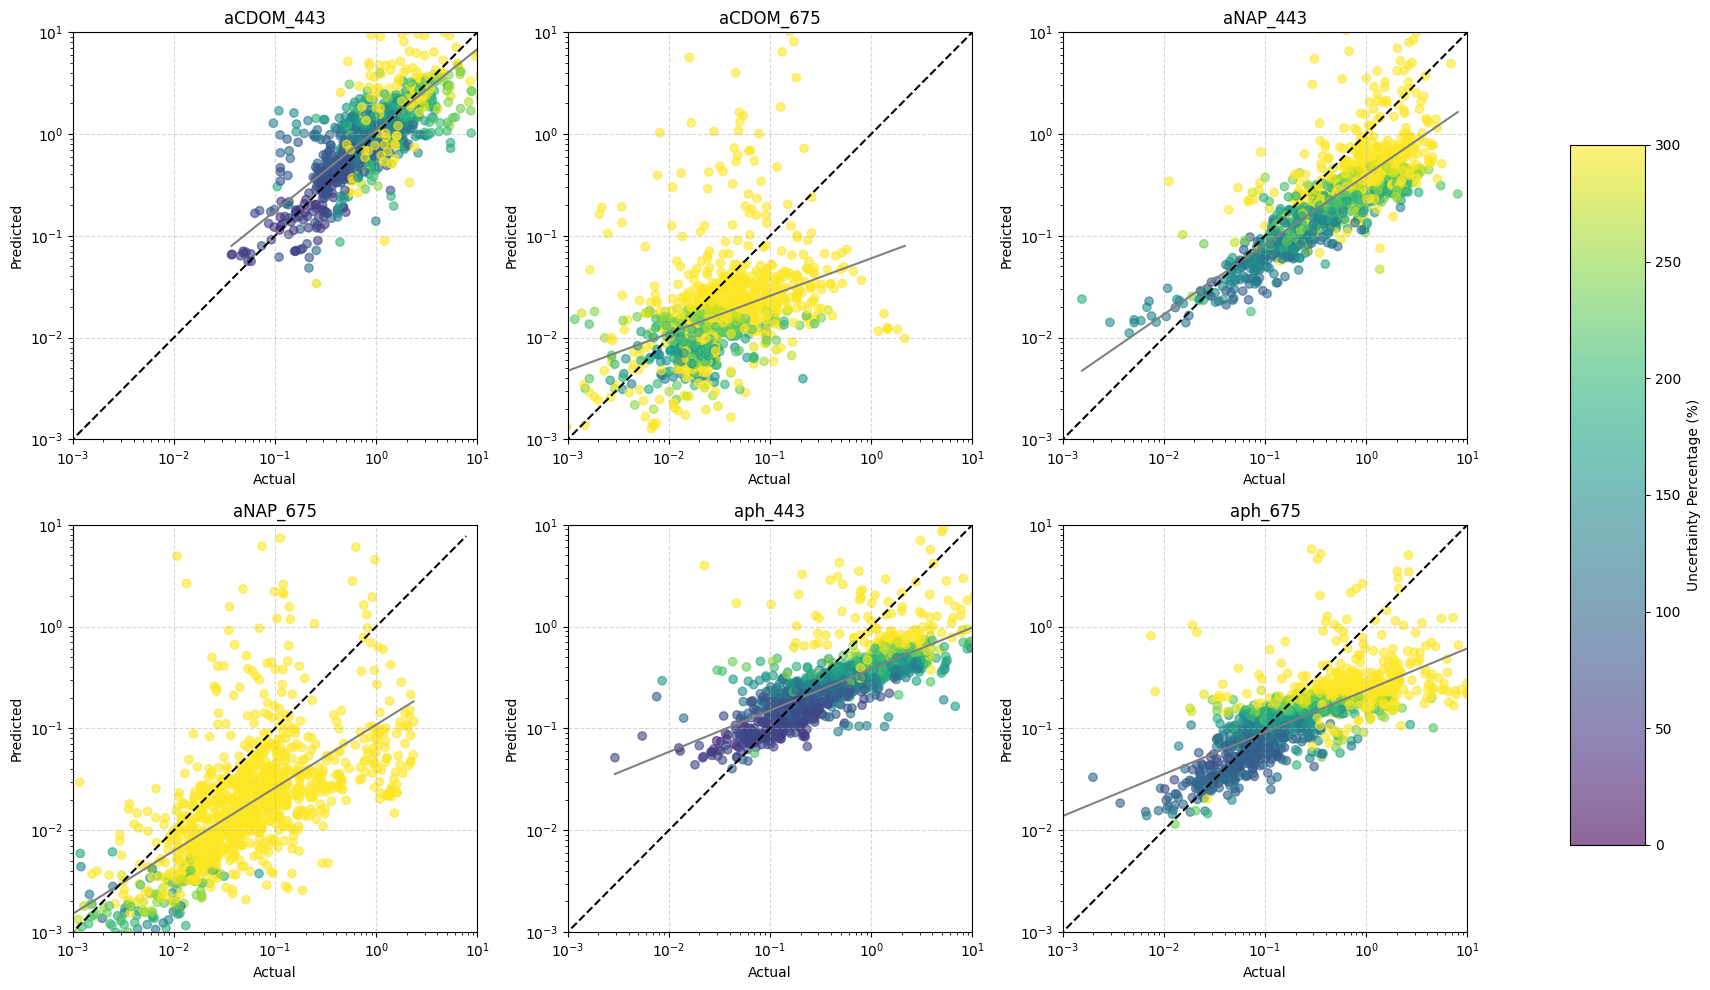

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
ood_percent_total_uncertainty = (np.sqrt(ood_total_var) / ood_mean_preds) * 100
ood_percent_aleatoric_uncertainty = (np.sqrt(ood_alea_var) / ood_mean_preds) * 100
ood_percent_epistemic_uncertainty = (np.sqrt(ood_epi_var) / ood_mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (ood_y_test > 1e-4) & (ood_mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=300)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = ood_y_test[:, i][mask[:, i]]
    y_values = ood_mean_preds[:, i][mask[:, i]]
    color_values = ood_percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')

    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


In [61]:
from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    ood_y_test,
    ood_mean_preds,
    ood_total_var,
    ood_alea_var,
    ood_epi_var,
    ood_std_devs
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=y_columns)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [1159, 1159, 1159, 1159, 1159, 1159])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(1159)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=y_columns)

final_df_multi_indexed_corrected

#save

file_path ='C:/SwitchDrive/Data/org_iop_model_predictions/mdn_ood_split_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)